# Face Generation

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

import helper

helper.download_extract('mnist', data_dir)

Found mnist Data


## Explore the Data
### MNIST

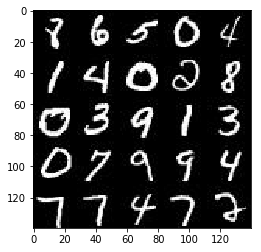

In [2]:
show_n_images = 25

% matplotlib inline
import os
import helper
data_dir = './data'
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA

In [1]:
show_n_images = 25

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

NameError: name 'helper' is not defined

## Preprocess the Data

In [4]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input

In [5]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate

Tests Passed


### Discriminator

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        keep_prob = 0.9
        
        # Input layer
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, 
                              padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer()) # Use xavier initializer
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.nn.dropout(relu1, keep_prob)
        
        # Conv layer
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, 
                              padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(relu2, keep_prob)
        
        # Conv layer
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, 
                              padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3, keep_prob)
        
        # Flat layer
        unit_num = relu3.get_shape()[1] * relu3.get_shape()[2] * relu3.get_shape()[3]
        flat = tf.reshape(relu3, (-1, int(unit_num)))
        
        # Logits
        logits = tf.layers.dense(flat, 1)
        
        # Output
        output = tf.sigmoid(logits)

    return output, logits

Tests Passed


### Generator

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        
        alpha = 0.2
        keep_prob = 0.9
        
        # Fully-connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        
        # Reshape
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.nn.dropout(relu1, keep_prob)
        
        # Conv_t layer
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, 
                                        padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.image.resize_nearest_neighbor(x2, (7, 7))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * x2, x2)
        relu2 = tf.nn.dropout(relu2, keep_prob)
        
        # Conv_t layer
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, 
                                        padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * x3, x3)
        relu3 = tf.nn.dropout(relu3, keep_prob)
        
        # Logits
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, 
                                            padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        # Output
        output = tf.tanh(logits)

    return output

Tests Passed


### Loss

In [8]:
import numpy as np

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real) * (1 - 0.1) + np.random.uniform(-0.05, 0.05)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.zeros_like(d_model_fake) + np.random.uniform(0.0, 0.1)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get variables
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimizer
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

Tests Passed


## Neural Network Training
### Show Output

In [10]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_Rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    print_num = 10
    show_num = 100
    
    show_images_num = 25
    
    # Get images information
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
        
    # Get inputs
    inputs_real, inputs_z, learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Get losses
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels)
    
    # Get optimizers
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_Rate, beta1)
    
#     saver = tf.train.Saver()
    
    ii = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                ii += 1
                    
                # Scale image inputs to (-1, 1)
                batch_images = batch_images * 2
                
                # Sample random noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, 
                                                     inputs_z: batch_z,
                                                     learning_rate: learning_Rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images, 
                                                     inputs_z: batch_z,
                                                     learning_rate: learning_Rate})
                
                if ii % print_num == 0:
                    # At losses
                    d_cost = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    g_cost = g_loss.eval({inputs_z: batch_z})
                    
                    print("Epoch: {}/{} |".format(epoch_i+1, epoch_count),
                          "Steps: {:>4} |".format(ii),
                          "Discriminator Loss: {:.4f} |".format(d_cost),
                          "Generator Loss: {:.4f}".format(g_cost))
                
                if ii % show_num == 0:
                    show_generator_output(sess, 
                                          show_images_num, 
                                          inputs_z, 
                                          image_channels, 
                                          data_image_mode)
            
#         saver.save(sess, './checkpoints/generator.ckpt')          

### MNIST

Epoch: 1/2 | Steps:   10 | Discriminator Loss: 0.7222 | Generator Loss: 3.5033
Epoch: 1/2 | Steps:   20 | Discriminator Loss: 0.7716 | Generator Loss: 5.5186
Epoch: 1/2 | Steps:   30 | Discriminator Loss: 1.2066 | Generator Loss: 1.3344
Epoch: 1/2 | Steps:   40 | Discriminator Loss: 1.4097 | Generator Loss: 1.0474
Epoch: 1/2 | Steps:   50 | Discriminator Loss: 1.4976 | Generator Loss: 0.6097
Epoch: 1/2 | Steps:   60 | Discriminator Loss: 1.1781 | Generator Loss: 1.5273
Epoch: 1/2 | Steps:   70 | Discriminator Loss: 1.3298 | Generator Loss: 1.1719
Epoch: 1/2 | Steps:   80 | Discriminator Loss: 1.1563 | Generator Loss: 0.8641
Epoch: 1/2 | Steps:   90 | Discriminator Loss: 0.8462 | Generator Loss: 1.3799
Epoch: 1/2 | Steps:  100 | Discriminator Loss: 0.7693 | Generator Loss: 1.8221


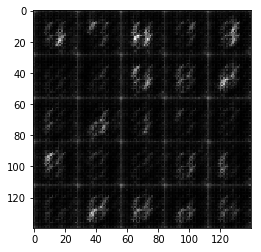

Epoch: 1/2 | Steps:  110 | Discriminator Loss: 1.0718 | Generator Loss: 3.3798
Epoch: 1/2 | Steps:  120 | Discriminator Loss: 1.1632 | Generator Loss: 0.8773
Epoch: 1/2 | Steps:  130 | Discriminator Loss: 1.0469 | Generator Loss: 1.4574
Epoch: 1/2 | Steps:  140 | Discriminator Loss: 0.7778 | Generator Loss: 1.7375
Epoch: 1/2 | Steps:  150 | Discriminator Loss: 0.8836 | Generator Loss: 1.8074
Epoch: 1/2 | Steps:  160 | Discriminator Loss: 0.8972 | Generator Loss: 1.3665
Epoch: 1/2 | Steps:  170 | Discriminator Loss: 1.1105 | Generator Loss: 3.2291
Epoch: 1/2 | Steps:  180 | Discriminator Loss: 0.9458 | Generator Loss: 1.8175
Epoch: 1/2 | Steps:  190 | Discriminator Loss: 0.8730 | Generator Loss: 1.6301
Epoch: 1/2 | Steps:  200 | Discriminator Loss: 1.1619 | Generator Loss: 1.3068


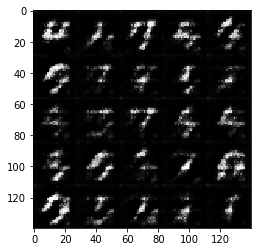

Epoch: 1/2 | Steps:  210 | Discriminator Loss: 0.9032 | Generator Loss: 2.2908
Epoch: 1/2 | Steps:  220 | Discriminator Loss: 0.8862 | Generator Loss: 2.0158
Epoch: 1/2 | Steps:  230 | Discriminator Loss: 0.8391 | Generator Loss: 1.8182
Epoch: 1/2 | Steps:  240 | Discriminator Loss: 1.0489 | Generator Loss: 1.0058
Epoch: 1/2 | Steps:  250 | Discriminator Loss: 1.3305 | Generator Loss: 0.7878
Epoch: 1/2 | Steps:  260 | Discriminator Loss: 1.2658 | Generator Loss: 1.1583
Epoch: 1/2 | Steps:  270 | Discriminator Loss: 1.2539 | Generator Loss: 1.2446
Epoch: 1/2 | Steps:  280 | Discriminator Loss: 1.1673 | Generator Loss: 1.1339
Epoch: 1/2 | Steps:  290 | Discriminator Loss: 1.1038 | Generator Loss: 1.1419
Epoch: 1/2 | Steps:  300 | Discriminator Loss: 1.1470 | Generator Loss: 1.1369


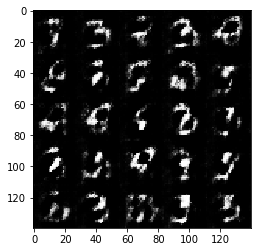

Epoch: 1/2 | Steps:  310 | Discriminator Loss: 1.1512 | Generator Loss: 0.8010
Epoch: 1/2 | Steps:  320 | Discriminator Loss: 1.2793 | Generator Loss: 0.8682
Epoch: 1/2 | Steps:  330 | Discriminator Loss: 1.2904 | Generator Loss: 1.2099
Epoch: 1/2 | Steps:  340 | Discriminator Loss: 1.1554 | Generator Loss: 1.6850
Epoch: 1/2 | Steps:  350 | Discriminator Loss: 1.1062 | Generator Loss: 1.4504
Epoch: 1/2 | Steps:  360 | Discriminator Loss: 1.2810 | Generator Loss: 1.8142
Epoch: 1/2 | Steps:  370 | Discriminator Loss: 1.1102 | Generator Loss: 1.0440
Epoch: 1/2 | Steps:  380 | Discriminator Loss: 1.2719 | Generator Loss: 0.7382
Epoch: 1/2 | Steps:  390 | Discriminator Loss: 1.1453 | Generator Loss: 0.9803
Epoch: 1/2 | Steps:  400 | Discriminator Loss: 1.2893 | Generator Loss: 0.7604


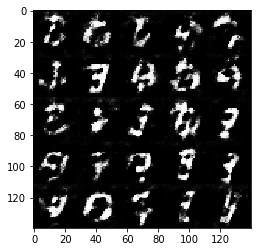

Epoch: 1/2 | Steps:  410 | Discriminator Loss: 0.9107 | Generator Loss: 1.5576
Epoch: 1/2 | Steps:  420 | Discriminator Loss: 1.1091 | Generator Loss: 1.1554
Epoch: 1/2 | Steps:  430 | Discriminator Loss: 1.1436 | Generator Loss: 0.8974
Epoch: 1/2 | Steps:  440 | Discriminator Loss: 1.3340 | Generator Loss: 0.9576
Epoch: 1/2 | Steps:  450 | Discriminator Loss: 0.9665 | Generator Loss: 1.2755
Epoch: 1/2 | Steps:  460 | Discriminator Loss: 1.0198 | Generator Loss: 1.0659
Epoch: 1/2 | Steps:  470 | Discriminator Loss: 1.0586 | Generator Loss: 1.0082
Epoch: 1/2 | Steps:  480 | Discriminator Loss: 1.0223 | Generator Loss: 0.8584
Epoch: 1/2 | Steps:  490 | Discriminator Loss: 1.0440 | Generator Loss: 0.8525
Epoch: 1/2 | Steps:  500 | Discriminator Loss: 1.1972 | Generator Loss: 1.1386


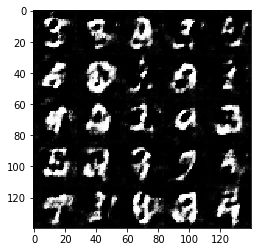

Epoch: 1/2 | Steps:  510 | Discriminator Loss: 1.2439 | Generator Loss: 0.7722
Epoch: 1/2 | Steps:  520 | Discriminator Loss: 1.1572 | Generator Loss: 1.2832
Epoch: 1/2 | Steps:  530 | Discriminator Loss: 1.1723 | Generator Loss: 0.7578
Epoch: 1/2 | Steps:  540 | Discriminator Loss: 1.2285 | Generator Loss: 0.6813
Epoch: 1/2 | Steps:  550 | Discriminator Loss: 1.0981 | Generator Loss: 0.9578
Epoch: 1/2 | Steps:  560 | Discriminator Loss: 0.9331 | Generator Loss: 1.2095
Epoch: 1/2 | Steps:  570 | Discriminator Loss: 1.1396 | Generator Loss: 1.2813
Epoch: 1/2 | Steps:  580 | Discriminator Loss: 1.0408 | Generator Loss: 1.0835
Epoch: 1/2 | Steps:  590 | Discriminator Loss: 1.0457 | Generator Loss: 1.2746
Epoch: 1/2 | Steps:  600 | Discriminator Loss: 1.0405 | Generator Loss: 1.1647


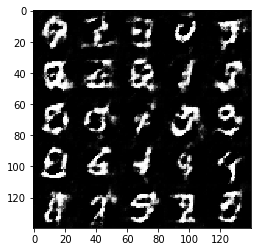

Epoch: 1/2 | Steps:  610 | Discriminator Loss: 1.1011 | Generator Loss: 0.8683
Epoch: 1/2 | Steps:  620 | Discriminator Loss: 1.0437 | Generator Loss: 1.0730
Epoch: 1/2 | Steps:  630 | Discriminator Loss: 0.9743 | Generator Loss: 1.3863
Epoch: 1/2 | Steps:  640 | Discriminator Loss: 1.0575 | Generator Loss: 1.4066
Epoch: 1/2 | Steps:  650 | Discriminator Loss: 1.0494 | Generator Loss: 0.8491
Epoch: 1/2 | Steps:  660 | Discriminator Loss: 1.0689 | Generator Loss: 1.5856
Epoch: 1/2 | Steps:  670 | Discriminator Loss: 1.1384 | Generator Loss: 0.7347
Epoch: 1/2 | Steps:  680 | Discriminator Loss: 1.0592 | Generator Loss: 1.6479
Epoch: 1/2 | Steps:  690 | Discriminator Loss: 0.9629 | Generator Loss: 1.2282
Epoch: 1/2 | Steps:  700 | Discriminator Loss: 1.0525 | Generator Loss: 0.9083


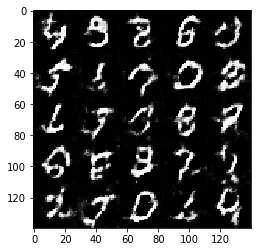

Epoch: 1/2 | Steps:  710 | Discriminator Loss: 0.9749 | Generator Loss: 1.0028
Epoch: 1/2 | Steps:  720 | Discriminator Loss: 1.1420 | Generator Loss: 0.9937
Epoch: 1/2 | Steps:  730 | Discriminator Loss: 1.2227 | Generator Loss: 0.7033
Epoch: 1/2 | Steps:  740 | Discriminator Loss: 0.9786 | Generator Loss: 1.2161
Epoch: 1/2 | Steps:  750 | Discriminator Loss: 1.0337 | Generator Loss: 1.0481
Epoch: 1/2 | Steps:  760 | Discriminator Loss: 0.9168 | Generator Loss: 1.2418
Epoch: 1/2 | Steps:  770 | Discriminator Loss: 1.3693 | Generator Loss: 0.5933
Epoch: 1/2 | Steps:  780 | Discriminator Loss: 1.1370 | Generator Loss: 0.9137
Epoch: 1/2 | Steps:  790 | Discriminator Loss: 1.0110 | Generator Loss: 1.1089
Epoch: 1/2 | Steps:  800 | Discriminator Loss: 1.1113 | Generator Loss: 0.8141


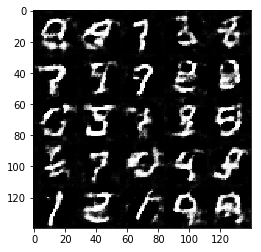

Epoch: 1/2 | Steps:  810 | Discriminator Loss: 1.2954 | Generator Loss: 1.1272
Epoch: 1/2 | Steps:  820 | Discriminator Loss: 1.0912 | Generator Loss: 1.4925
Epoch: 1/2 | Steps:  830 | Discriminator Loss: 1.1620 | Generator Loss: 0.8121
Epoch: 1/2 | Steps:  840 | Discriminator Loss: 1.5635 | Generator Loss: 0.4783
Epoch: 1/2 | Steps:  850 | Discriminator Loss: 1.0847 | Generator Loss: 1.0658
Epoch: 1/2 | Steps:  860 | Discriminator Loss: 1.2839 | Generator Loss: 1.0827
Epoch: 1/2 | Steps:  870 | Discriminator Loss: 1.0866 | Generator Loss: 0.9958
Epoch: 1/2 | Steps:  880 | Discriminator Loss: 0.9520 | Generator Loss: 1.5761
Epoch: 1/2 | Steps:  890 | Discriminator Loss: 1.2622 | Generator Loss: 0.6216
Epoch: 1/2 | Steps:  900 | Discriminator Loss: 1.0991 | Generator Loss: 1.0106


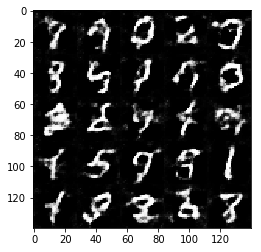

Epoch: 1/2 | Steps:  910 | Discriminator Loss: 1.1555 | Generator Loss: 1.0781
Epoch: 1/2 | Steps:  920 | Discriminator Loss: 0.9639 | Generator Loss: 1.1215
Epoch: 1/2 | Steps:  930 | Discriminator Loss: 1.1979 | Generator Loss: 0.7655
Epoch: 1/2 | Steps:  940 | Discriminator Loss: 1.3964 | Generator Loss: 0.5232
Epoch: 1/2 | Steps:  950 | Discriminator Loss: 0.9640 | Generator Loss: 0.9478
Epoch: 1/2 | Steps:  960 | Discriminator Loss: 1.0921 | Generator Loss: 1.3397
Epoch: 1/2 | Steps:  970 | Discriminator Loss: 1.0796 | Generator Loss: 0.9015
Epoch: 1/2 | Steps:  980 | Discriminator Loss: 1.1655 | Generator Loss: 0.5777
Epoch: 1/2 | Steps:  990 | Discriminator Loss: 1.1108 | Generator Loss: 1.4772
Epoch: 1/2 | Steps: 1000 | Discriminator Loss: 1.1203 | Generator Loss: 0.8736


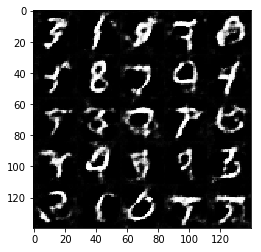

Epoch: 1/2 | Steps: 1010 | Discriminator Loss: 1.4028 | Generator Loss: 0.4277
Epoch: 1/2 | Steps: 1020 | Discriminator Loss: 1.1394 | Generator Loss: 0.6814
Epoch: 1/2 | Steps: 1030 | Discriminator Loss: 1.1119 | Generator Loss: 1.1064
Epoch: 1/2 | Steps: 1040 | Discriminator Loss: 0.9939 | Generator Loss: 1.1391
Epoch: 1/2 | Steps: 1050 | Discriminator Loss: 0.9965 | Generator Loss: 1.4931
Epoch: 1/2 | Steps: 1060 | Discriminator Loss: 1.0327 | Generator Loss: 0.9261
Epoch: 1/2 | Steps: 1070 | Discriminator Loss: 1.0589 | Generator Loss: 1.1156
Epoch: 1/2 | Steps: 1080 | Discriminator Loss: 1.0824 | Generator Loss: 1.2898
Epoch: 1/2 | Steps: 1090 | Discriminator Loss: 1.0782 | Generator Loss: 1.0861
Epoch: 1/2 | Steps: 1100 | Discriminator Loss: 1.0152 | Generator Loss: 0.7497


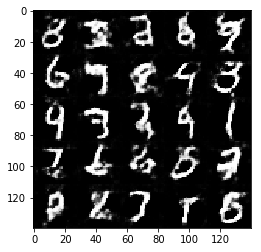

Epoch: 1/2 | Steps: 1110 | Discriminator Loss: 1.2062 | Generator Loss: 0.8823
Epoch: 1/2 | Steps: 1120 | Discriminator Loss: 0.9990 | Generator Loss: 1.2022
Epoch: 1/2 | Steps: 1130 | Discriminator Loss: 1.1789 | Generator Loss: 0.9793
Epoch: 1/2 | Steps: 1140 | Discriminator Loss: 1.1651 | Generator Loss: 0.8261
Epoch: 1/2 | Steps: 1150 | Discriminator Loss: 1.3121 | Generator Loss: 0.5269
Epoch: 1/2 | Steps: 1160 | Discriminator Loss: 1.0151 | Generator Loss: 1.2948
Epoch: 1/2 | Steps: 1170 | Discriminator Loss: 1.1559 | Generator Loss: 0.9479
Epoch: 1/2 | Steps: 1180 | Discriminator Loss: 1.1300 | Generator Loss: 0.9129
Epoch: 1/2 | Steps: 1190 | Discriminator Loss: 1.2087 | Generator Loss: 1.8038
Epoch: 1/2 | Steps: 1200 | Discriminator Loss: 1.1246 | Generator Loss: 0.8679


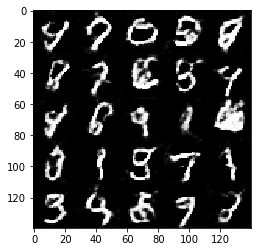

Epoch: 1/2 | Steps: 1210 | Discriminator Loss: 1.3976 | Generator Loss: 0.5900
Epoch: 1/2 | Steps: 1220 | Discriminator Loss: 1.3387 | Generator Loss: 1.6261
Epoch: 1/2 | Steps: 1230 | Discriminator Loss: 1.0190 | Generator Loss: 1.2125
Epoch: 1/2 | Steps: 1240 | Discriminator Loss: 1.1211 | Generator Loss: 0.9031
Epoch: 1/2 | Steps: 1250 | Discriminator Loss: 1.2936 | Generator Loss: 0.6122
Epoch: 1/2 | Steps: 1260 | Discriminator Loss: 1.0070 | Generator Loss: 1.2820
Epoch: 1/2 | Steps: 1270 | Discriminator Loss: 1.2106 | Generator Loss: 0.8085
Epoch: 1/2 | Steps: 1280 | Discriminator Loss: 0.9586 | Generator Loss: 0.9519
Epoch: 1/2 | Steps: 1290 | Discriminator Loss: 1.0641 | Generator Loss: 0.8233
Epoch: 1/2 | Steps: 1300 | Discriminator Loss: 0.9413 | Generator Loss: 1.3026


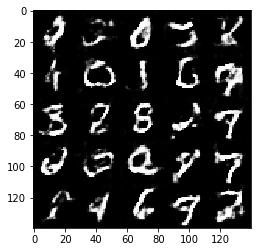

Epoch: 1/2 | Steps: 1310 | Discriminator Loss: 1.1619 | Generator Loss: 0.9520
Epoch: 1/2 | Steps: 1320 | Discriminator Loss: 1.0902 | Generator Loss: 0.8586
Epoch: 1/2 | Steps: 1330 | Discriminator Loss: 1.0795 | Generator Loss: 1.4696
Epoch: 1/2 | Steps: 1340 | Discriminator Loss: 1.1997 | Generator Loss: 0.7605
Epoch: 1/2 | Steps: 1350 | Discriminator Loss: 1.1666 | Generator Loss: 1.1790
Epoch: 1/2 | Steps: 1360 | Discriminator Loss: 0.9768 | Generator Loss: 0.9968
Epoch: 1/2 | Steps: 1370 | Discriminator Loss: 1.1484 | Generator Loss: 1.0438
Epoch: 1/2 | Steps: 1380 | Discriminator Loss: 1.0873 | Generator Loss: 1.0972
Epoch: 1/2 | Steps: 1390 | Discriminator Loss: 0.9825 | Generator Loss: 1.1818
Epoch: 1/2 | Steps: 1400 | Discriminator Loss: 1.0741 | Generator Loss: 1.0862


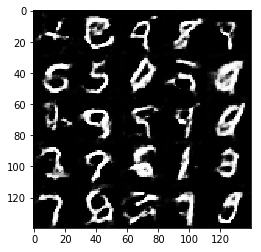

Epoch: 1/2 | Steps: 1410 | Discriminator Loss: 1.0755 | Generator Loss: 1.0303
Epoch: 1/2 | Steps: 1420 | Discriminator Loss: 1.1864 | Generator Loss: 0.8468
Epoch: 1/2 | Steps: 1430 | Discriminator Loss: 1.0177 | Generator Loss: 0.9676
Epoch: 1/2 | Steps: 1440 | Discriminator Loss: 1.2555 | Generator Loss: 1.9115
Epoch: 1/2 | Steps: 1450 | Discriminator Loss: 1.0786 | Generator Loss: 0.9483
Epoch: 1/2 | Steps: 1460 | Discriminator Loss: 1.2336 | Generator Loss: 0.8731
Epoch: 1/2 | Steps: 1470 | Discriminator Loss: 1.2849 | Generator Loss: 0.5331
Epoch: 1/2 | Steps: 1480 | Discriminator Loss: 0.9280 | Generator Loss: 1.6800
Epoch: 1/2 | Steps: 1490 | Discriminator Loss: 0.9197 | Generator Loss: 1.2760
Epoch: 1/2 | Steps: 1500 | Discriminator Loss: 1.0331 | Generator Loss: 1.1834


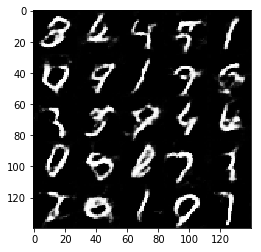

Epoch: 1/2 | Steps: 1510 | Discriminator Loss: 1.0901 | Generator Loss: 0.9582
Epoch: 1/2 | Steps: 1520 | Discriminator Loss: 1.1386 | Generator Loss: 1.3215
Epoch: 1/2 | Steps: 1530 | Discriminator Loss: 1.1258 | Generator Loss: 0.9192
Epoch: 1/2 | Steps: 1540 | Discriminator Loss: 1.0265 | Generator Loss: 1.0632
Epoch: 1/2 | Steps: 1550 | Discriminator Loss: 1.0989 | Generator Loss: 0.9268
Epoch: 1/2 | Steps: 1560 | Discriminator Loss: 1.0677 | Generator Loss: 1.0286
Epoch: 1/2 | Steps: 1570 | Discriminator Loss: 1.1342 | Generator Loss: 0.7568
Epoch: 1/2 | Steps: 1580 | Discriminator Loss: 1.0236 | Generator Loss: 0.8345
Epoch: 1/2 | Steps: 1590 | Discriminator Loss: 1.1658 | Generator Loss: 0.8463
Epoch: 1/2 | Steps: 1600 | Discriminator Loss: 1.1899 | Generator Loss: 1.7620


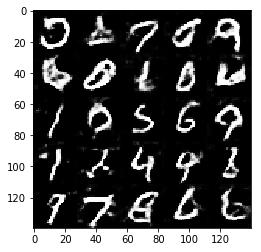

Epoch: 1/2 | Steps: 1610 | Discriminator Loss: 1.0970 | Generator Loss: 1.0356
Epoch: 1/2 | Steps: 1620 | Discriminator Loss: 0.9519 | Generator Loss: 1.3582
Epoch: 1/2 | Steps: 1630 | Discriminator Loss: 1.0527 | Generator Loss: 1.0488
Epoch: 1/2 | Steps: 1640 | Discriminator Loss: 1.1069 | Generator Loss: 0.9963
Epoch: 1/2 | Steps: 1650 | Discriminator Loss: 1.0852 | Generator Loss: 0.9764
Epoch: 1/2 | Steps: 1660 | Discriminator Loss: 1.2734 | Generator Loss: 1.4078
Epoch: 1/2 | Steps: 1670 | Discriminator Loss: 1.1291 | Generator Loss: 0.9959
Epoch: 1/2 | Steps: 1680 | Discriminator Loss: 1.0766 | Generator Loss: 1.1335
Epoch: 1/2 | Steps: 1690 | Discriminator Loss: 0.9653 | Generator Loss: 1.0731
Epoch: 1/2 | Steps: 1700 | Discriminator Loss: 1.0427 | Generator Loss: 1.3388


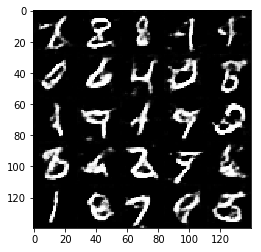

Epoch: 1/2 | Steps: 1710 | Discriminator Loss: 1.0543 | Generator Loss: 1.3994
Epoch: 1/2 | Steps: 1720 | Discriminator Loss: 1.1324 | Generator Loss: 0.6633
Epoch: 1/2 | Steps: 1730 | Discriminator Loss: 0.9111 | Generator Loss: 1.8121
Epoch: 1/2 | Steps: 1740 | Discriminator Loss: 1.2157 | Generator Loss: 1.3698
Epoch: 1/2 | Steps: 1750 | Discriminator Loss: 1.1233 | Generator Loss: 0.7889
Epoch: 1/2 | Steps: 1760 | Discriminator Loss: 1.0872 | Generator Loss: 1.0197
Epoch: 1/2 | Steps: 1770 | Discriminator Loss: 1.0646 | Generator Loss: 1.5998
Epoch: 1/2 | Steps: 1780 | Discriminator Loss: 1.0591 | Generator Loss: 1.0856
Epoch: 1/2 | Steps: 1790 | Discriminator Loss: 1.0695 | Generator Loss: 0.7870
Epoch: 1/2 | Steps: 1800 | Discriminator Loss: 1.0329 | Generator Loss: 1.0631


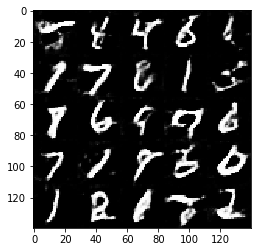

Epoch: 1/2 | Steps: 1810 | Discriminator Loss: 1.1174 | Generator Loss: 1.2970
Epoch: 1/2 | Steps: 1820 | Discriminator Loss: 0.9566 | Generator Loss: 1.2231
Epoch: 1/2 | Steps: 1830 | Discriminator Loss: 1.1309 | Generator Loss: 1.6542
Epoch: 1/2 | Steps: 1840 | Discriminator Loss: 0.9027 | Generator Loss: 1.2628
Epoch: 1/2 | Steps: 1850 | Discriminator Loss: 1.0274 | Generator Loss: 0.9486
Epoch: 1/2 | Steps: 1860 | Discriminator Loss: 1.1319 | Generator Loss: 0.8392
Epoch: 1/2 | Steps: 1870 | Discriminator Loss: 1.0513 | Generator Loss: 0.9777
Epoch: 2/2 | Steps: 1880 | Discriminator Loss: 0.9140 | Generator Loss: 1.1065
Epoch: 2/2 | Steps: 1890 | Discriminator Loss: 1.0875 | Generator Loss: 1.0362
Epoch: 2/2 | Steps: 1900 | Discriminator Loss: 0.9644 | Generator Loss: 1.2748


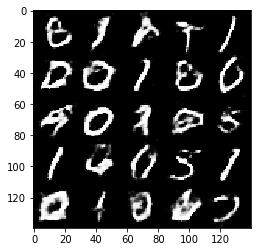

Epoch: 2/2 | Steps: 1910 | Discriminator Loss: 1.3696 | Generator Loss: 0.5117
Epoch: 2/2 | Steps: 1920 | Discriminator Loss: 1.0121 | Generator Loss: 1.1882
Epoch: 2/2 | Steps: 1930 | Discriminator Loss: 1.0028 | Generator Loss: 1.0868
Epoch: 2/2 | Steps: 1940 | Discriminator Loss: 0.9954 | Generator Loss: 0.9056
Epoch: 2/2 | Steps: 1950 | Discriminator Loss: 1.1182 | Generator Loss: 1.6557
Epoch: 2/2 | Steps: 1960 | Discriminator Loss: 0.9681 | Generator Loss: 1.2002
Epoch: 2/2 | Steps: 1970 | Discriminator Loss: 1.0476 | Generator Loss: 1.1813
Epoch: 2/2 | Steps: 1980 | Discriminator Loss: 0.9676 | Generator Loss: 1.5569
Epoch: 2/2 | Steps: 1990 | Discriminator Loss: 1.0697 | Generator Loss: 1.3955
Epoch: 2/2 | Steps: 2000 | Discriminator Loss: 1.0346 | Generator Loss: 1.0060


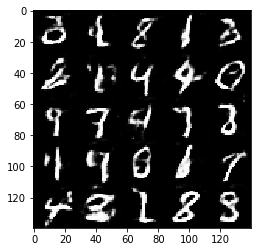

Epoch: 2/2 | Steps: 2010 | Discriminator Loss: 0.9662 | Generator Loss: 1.2057
Epoch: 2/2 | Steps: 2020 | Discriminator Loss: 0.9277 | Generator Loss: 1.2485
Epoch: 2/2 | Steps: 2030 | Discriminator Loss: 1.0101 | Generator Loss: 1.0182
Epoch: 2/2 | Steps: 2040 | Discriminator Loss: 0.9030 | Generator Loss: 1.0727
Epoch: 2/2 | Steps: 2050 | Discriminator Loss: 0.8488 | Generator Loss: 1.1989
Epoch: 2/2 | Steps: 2060 | Discriminator Loss: 1.0041 | Generator Loss: 0.8623
Epoch: 2/2 | Steps: 2070 | Discriminator Loss: 1.0869 | Generator Loss: 0.9158
Epoch: 2/2 | Steps: 2080 | Discriminator Loss: 2.2209 | Generator Loss: 0.2134
Epoch: 2/2 | Steps: 2090 | Discriminator Loss: 1.1575 | Generator Loss: 0.8181
Epoch: 2/2 | Steps: 2100 | Discriminator Loss: 0.9085 | Generator Loss: 1.2814


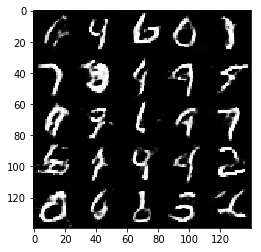

Epoch: 2/2 | Steps: 2110 | Discriminator Loss: 0.9635 | Generator Loss: 0.8458
Epoch: 2/2 | Steps: 2120 | Discriminator Loss: 0.9763 | Generator Loss: 1.0334
Epoch: 2/2 | Steps: 2130 | Discriminator Loss: 1.0916 | Generator Loss: 0.8939
Epoch: 2/2 | Steps: 2140 | Discriminator Loss: 0.9298 | Generator Loss: 1.2638
Epoch: 2/2 | Steps: 2150 | Discriminator Loss: 0.8168 | Generator Loss: 1.3626
Epoch: 2/2 | Steps: 2160 | Discriminator Loss: 1.0383 | Generator Loss: 0.7784
Epoch: 2/2 | Steps: 2170 | Discriminator Loss: 1.0371 | Generator Loss: 0.8874
Epoch: 2/2 | Steps: 2180 | Discriminator Loss: 0.9554 | Generator Loss: 1.3799
Epoch: 2/2 | Steps: 2190 | Discriminator Loss: 0.9927 | Generator Loss: 1.2818
Epoch: 2/2 | Steps: 2200 | Discriminator Loss: 1.0000 | Generator Loss: 1.7787


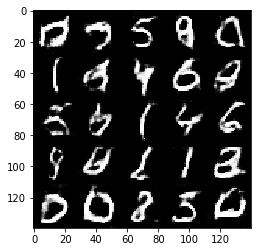

Epoch: 2/2 | Steps: 2210 | Discriminator Loss: 0.9553 | Generator Loss: 1.0872
Epoch: 2/2 | Steps: 2220 | Discriminator Loss: 0.8208 | Generator Loss: 1.7598
Epoch: 2/2 | Steps: 2230 | Discriminator Loss: 0.9301 | Generator Loss: 0.9756
Epoch: 2/2 | Steps: 2240 | Discriminator Loss: 1.8368 | Generator Loss: 0.3176
Epoch: 2/2 | Steps: 2250 | Discriminator Loss: 0.9846 | Generator Loss: 1.8506
Epoch: 2/2 | Steps: 2260 | Discriminator Loss: 0.8292 | Generator Loss: 1.2433
Epoch: 2/2 | Steps: 2270 | Discriminator Loss: 1.0428 | Generator Loss: 0.9070
Epoch: 2/2 | Steps: 2280 | Discriminator Loss: 0.9722 | Generator Loss: 1.0229
Epoch: 2/2 | Steps: 2290 | Discriminator Loss: 0.9649 | Generator Loss: 1.0034
Epoch: 2/2 | Steps: 2300 | Discriminator Loss: 1.0296 | Generator Loss: 1.0478


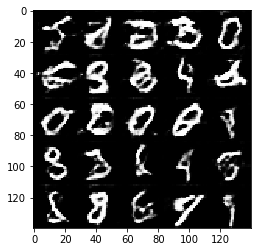

Epoch: 2/2 | Steps: 2310 | Discriminator Loss: 1.1278 | Generator Loss: 0.6918
Epoch: 2/2 | Steps: 2320 | Discriminator Loss: 1.1423 | Generator Loss: 0.7524
Epoch: 2/2 | Steps: 2330 | Discriminator Loss: 0.9813 | Generator Loss: 1.2883
Epoch: 2/2 | Steps: 2340 | Discriminator Loss: 0.8252 | Generator Loss: 1.3384
Epoch: 2/2 | Steps: 2350 | Discriminator Loss: 0.9669 | Generator Loss: 1.5813
Epoch: 2/2 | Steps: 2360 | Discriminator Loss: 0.8755 | Generator Loss: 1.6295
Epoch: 2/2 | Steps: 2370 | Discriminator Loss: 0.9239 | Generator Loss: 1.6198
Epoch: 2/2 | Steps: 2380 | Discriminator Loss: 0.8735 | Generator Loss: 1.3642
Epoch: 2/2 | Steps: 2390 | Discriminator Loss: 0.7794 | Generator Loss: 1.3553
Epoch: 2/2 | Steps: 2400 | Discriminator Loss: 0.9701 | Generator Loss: 1.5914


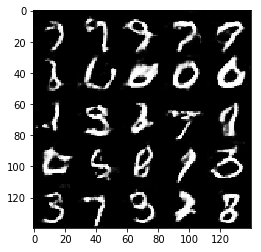

Epoch: 2/2 | Steps: 2410 | Discriminator Loss: 0.8076 | Generator Loss: 1.5766
Epoch: 2/2 | Steps: 2420 | Discriminator Loss: 0.9430 | Generator Loss: 1.3505
Epoch: 2/2 | Steps: 2430 | Discriminator Loss: 1.1279 | Generator Loss: 2.2688
Epoch: 2/2 | Steps: 2440 | Discriminator Loss: 1.0852 | Generator Loss: 1.2142
Epoch: 2/2 | Steps: 2450 | Discriminator Loss: 1.0000 | Generator Loss: 1.8528
Epoch: 2/2 | Steps: 2460 | Discriminator Loss: 0.9422 | Generator Loss: 1.1305
Epoch: 2/2 | Steps: 2470 | Discriminator Loss: 0.8587 | Generator Loss: 1.7110
Epoch: 2/2 | Steps: 2480 | Discriminator Loss: 0.8700 | Generator Loss: 1.3576
Epoch: 2/2 | Steps: 2490 | Discriminator Loss: 0.9771 | Generator Loss: 1.2598
Epoch: 2/2 | Steps: 2500 | Discriminator Loss: 0.9238 | Generator Loss: 1.8409


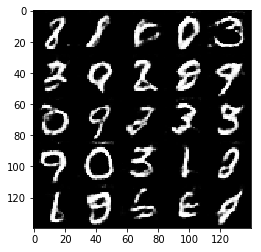

Epoch: 2/2 | Steps: 2510 | Discriminator Loss: 1.1763 | Generator Loss: 0.6161
Epoch: 2/2 | Steps: 2520 | Discriminator Loss: 1.1916 | Generator Loss: 0.9561
Epoch: 2/2 | Steps: 2530 | Discriminator Loss: 0.9407 | Generator Loss: 1.1639
Epoch: 2/2 | Steps: 2540 | Discriminator Loss: 0.8203 | Generator Loss: 1.5676
Epoch: 2/2 | Steps: 2550 | Discriminator Loss: 0.8545 | Generator Loss: 1.0262
Epoch: 2/2 | Steps: 2560 | Discriminator Loss: 1.0935 | Generator Loss: 0.8175
Epoch: 2/2 | Steps: 2570 | Discriminator Loss: 1.0153 | Generator Loss: 0.9282
Epoch: 2/2 | Steps: 2580 | Discriminator Loss: 0.8598 | Generator Loss: 1.7109
Epoch: 2/2 | Steps: 2590 | Discriminator Loss: 0.8810 | Generator Loss: 1.0424
Epoch: 2/2 | Steps: 2600 | Discriminator Loss: 0.8710 | Generator Loss: 1.1302


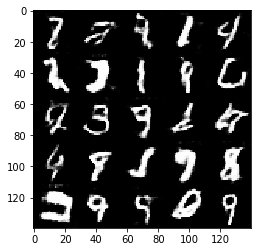

Epoch: 2/2 | Steps: 2610 | Discriminator Loss: 0.8820 | Generator Loss: 1.2400
Epoch: 2/2 | Steps: 2620 | Discriminator Loss: 1.3351 | Generator Loss: 0.5694
Epoch: 2/2 | Steps: 2630 | Discriminator Loss: 1.0403 | Generator Loss: 1.1040
Epoch: 2/2 | Steps: 2640 | Discriminator Loss: 0.8770 | Generator Loss: 1.4832
Epoch: 2/2 | Steps: 2650 | Discriminator Loss: 0.7762 | Generator Loss: 1.5523
Epoch: 2/2 | Steps: 2660 | Discriminator Loss: 1.0119 | Generator Loss: 1.5805
Epoch: 2/2 | Steps: 2670 | Discriminator Loss: 1.1027 | Generator Loss: 1.0610
Epoch: 2/2 | Steps: 2680 | Discriminator Loss: 1.0730 | Generator Loss: 1.3489
Epoch: 2/2 | Steps: 2690 | Discriminator Loss: 0.9249 | Generator Loss: 1.2727
Epoch: 2/2 | Steps: 2700 | Discriminator Loss: 1.5849 | Generator Loss: 2.5315


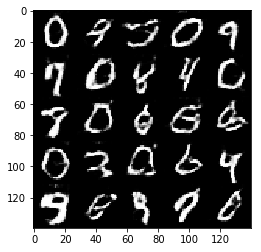

Epoch: 2/2 | Steps: 2710 | Discriminator Loss: 0.9479 | Generator Loss: 1.2913
Epoch: 2/2 | Steps: 2720 | Discriminator Loss: 0.8703 | Generator Loss: 1.3134
Epoch: 2/2 | Steps: 2730 | Discriminator Loss: 0.8199 | Generator Loss: 1.2659
Epoch: 2/2 | Steps: 2740 | Discriminator Loss: 0.8832 | Generator Loss: 0.9372
Epoch: 2/2 | Steps: 2750 | Discriminator Loss: 0.9188 | Generator Loss: 1.6501
Epoch: 2/2 | Steps: 2760 | Discriminator Loss: 0.9155 | Generator Loss: 1.3354
Epoch: 2/2 | Steps: 2770 | Discriminator Loss: 0.8846 | Generator Loss: 1.1268
Epoch: 2/2 | Steps: 2780 | Discriminator Loss: 1.0930 | Generator Loss: 0.7981
Epoch: 2/2 | Steps: 2790 | Discriminator Loss: 0.9294 | Generator Loss: 0.9664
Epoch: 2/2 | Steps: 2800 | Discriminator Loss: 0.7236 | Generator Loss: 1.4670


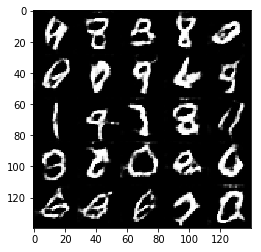

Epoch: 2/2 | Steps: 2810 | Discriminator Loss: 0.7990 | Generator Loss: 0.9262
Epoch: 2/2 | Steps: 2820 | Discriminator Loss: 0.9578 | Generator Loss: 1.4047
Epoch: 2/2 | Steps: 2830 | Discriminator Loss: 0.8877 | Generator Loss: 1.1436
Epoch: 2/2 | Steps: 2840 | Discriminator Loss: 1.1110 | Generator Loss: 1.2519
Epoch: 2/2 | Steps: 2850 | Discriminator Loss: 1.0212 | Generator Loss: 0.8829
Epoch: 2/2 | Steps: 2860 | Discriminator Loss: 0.8737 | Generator Loss: 1.7959
Epoch: 2/2 | Steps: 2870 | Discriminator Loss: 0.9789 | Generator Loss: 0.9400
Epoch: 2/2 | Steps: 2880 | Discriminator Loss: 0.8357 | Generator Loss: 1.7130
Epoch: 2/2 | Steps: 2890 | Discriminator Loss: 1.0937 | Generator Loss: 1.8320
Epoch: 2/2 | Steps: 2900 | Discriminator Loss: 0.9060 | Generator Loss: 1.8556


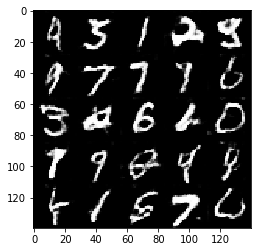

Epoch: 2/2 | Steps: 2910 | Discriminator Loss: 0.9762 | Generator Loss: 1.3343
Epoch: 2/2 | Steps: 2920 | Discriminator Loss: 0.8423 | Generator Loss: 1.7955
Epoch: 2/2 | Steps: 2930 | Discriminator Loss: 0.8789 | Generator Loss: 1.6963
Epoch: 2/2 | Steps: 2940 | Discriminator Loss: 0.7952 | Generator Loss: 1.6583
Epoch: 2/2 | Steps: 2950 | Discriminator Loss: 0.7482 | Generator Loss: 1.1036
Epoch: 2/2 | Steps: 2960 | Discriminator Loss: 0.8524 | Generator Loss: 1.5451
Epoch: 2/2 | Steps: 2970 | Discriminator Loss: 0.8711 | Generator Loss: 1.3727
Epoch: 2/2 | Steps: 2980 | Discriminator Loss: 0.9575 | Generator Loss: 0.7890
Epoch: 2/2 | Steps: 2990 | Discriminator Loss: 0.9371 | Generator Loss: 1.4970
Epoch: 2/2 | Steps: 3000 | Discriminator Loss: 0.9536 | Generator Loss: 0.9036


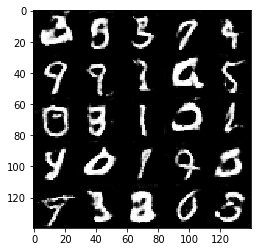

Epoch: 2/2 | Steps: 3010 | Discriminator Loss: 1.0026 | Generator Loss: 1.2884
Epoch: 2/2 | Steps: 3020 | Discriminator Loss: 0.9995 | Generator Loss: 1.3944
Epoch: 2/2 | Steps: 3030 | Discriminator Loss: 0.8461 | Generator Loss: 1.1463
Epoch: 2/2 | Steps: 3040 | Discriminator Loss: 0.8479 | Generator Loss: 1.2125
Epoch: 2/2 | Steps: 3050 | Discriminator Loss: 0.8943 | Generator Loss: 1.5416
Epoch: 2/2 | Steps: 3060 | Discriminator Loss: 0.9719 | Generator Loss: 1.0002
Epoch: 2/2 | Steps: 3070 | Discriminator Loss: 0.7271 | Generator Loss: 1.6733
Epoch: 2/2 | Steps: 3080 | Discriminator Loss: 0.9104 | Generator Loss: 1.4425
Epoch: 2/2 | Steps: 3090 | Discriminator Loss: 0.8106 | Generator Loss: 1.3846
Epoch: 2/2 | Steps: 3100 | Discriminator Loss: 0.9967 | Generator Loss: 0.6867


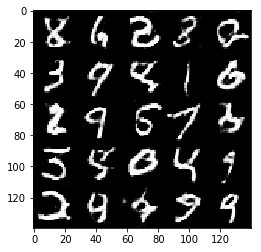

Epoch: 2/2 | Steps: 3110 | Discriminator Loss: 0.9863 | Generator Loss: 1.0395
Epoch: 2/2 | Steps: 3120 | Discriminator Loss: 0.8349 | Generator Loss: 1.4523
Epoch: 2/2 | Steps: 3130 | Discriminator Loss: 0.8404 | Generator Loss: 1.3863
Epoch: 2/2 | Steps: 3140 | Discriminator Loss: 0.8961 | Generator Loss: 1.1276
Epoch: 2/2 | Steps: 3150 | Discriminator Loss: 0.8894 | Generator Loss: 1.1049
Epoch: 2/2 | Steps: 3160 | Discriminator Loss: 0.8607 | Generator Loss: 1.7026
Epoch: 2/2 | Steps: 3170 | Discriminator Loss: 1.7951 | Generator Loss: 0.3685
Epoch: 2/2 | Steps: 3180 | Discriminator Loss: 1.1924 | Generator Loss: 1.4877
Epoch: 2/2 | Steps: 3190 | Discriminator Loss: 1.0966 | Generator Loss: 0.9037
Epoch: 2/2 | Steps: 3200 | Discriminator Loss: 0.9202 | Generator Loss: 1.0566


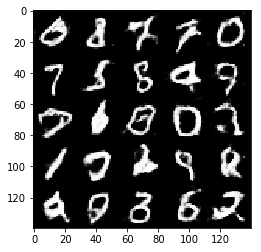

Epoch: 2/2 | Steps: 3210 | Discriminator Loss: 0.8621 | Generator Loss: 1.1605
Epoch: 2/2 | Steps: 3220 | Discriminator Loss: 0.7863 | Generator Loss: 1.6319
Epoch: 2/2 | Steps: 3230 | Discriminator Loss: 0.8687 | Generator Loss: 1.2482
Epoch: 2/2 | Steps: 3240 | Discriminator Loss: 0.7481 | Generator Loss: 1.8762
Epoch: 2/2 | Steps: 3250 | Discriminator Loss: 0.7690 | Generator Loss: 1.5578
Epoch: 2/2 | Steps: 3260 | Discriminator Loss: 0.9200 | Generator Loss: 1.1293
Epoch: 2/2 | Steps: 3270 | Discriminator Loss: 0.8489 | Generator Loss: 1.3355
Epoch: 2/2 | Steps: 3280 | Discriminator Loss: 1.0135 | Generator Loss: 0.9851
Epoch: 2/2 | Steps: 3290 | Discriminator Loss: 0.9211 | Generator Loss: 1.3799
Epoch: 2/2 | Steps: 3300 | Discriminator Loss: 0.9247 | Generator Loss: 1.1951


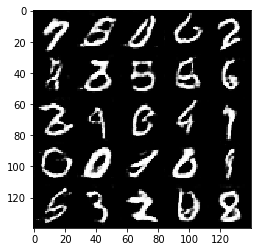

Epoch: 2/2 | Steps: 3310 | Discriminator Loss: 0.8572 | Generator Loss: 1.3725
Epoch: 2/2 | Steps: 3320 | Discriminator Loss: 0.8923 | Generator Loss: 1.6480
Epoch: 2/2 | Steps: 3330 | Discriminator Loss: 0.8312 | Generator Loss: 1.0425
Epoch: 2/2 | Steps: 3340 | Discriminator Loss: 1.0273 | Generator Loss: 0.6788
Epoch: 2/2 | Steps: 3350 | Discriminator Loss: 0.8177 | Generator Loss: 1.3966
Epoch: 2/2 | Steps: 3360 | Discriminator Loss: 0.9356 | Generator Loss: 1.0557
Epoch: 2/2 | Steps: 3370 | Discriminator Loss: 0.9378 | Generator Loss: 0.9159
Epoch: 2/2 | Steps: 3380 | Discriminator Loss: 0.8154 | Generator Loss: 2.1019
Epoch: 2/2 | Steps: 3390 | Discriminator Loss: 0.8487 | Generator Loss: 1.2777
Epoch: 2/2 | Steps: 3400 | Discriminator Loss: 0.7441 | Generator Loss: 1.6125


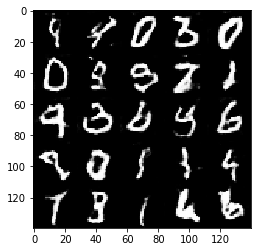

Epoch: 2/2 | Steps: 3410 | Discriminator Loss: 1.2967 | Generator Loss: 1.7362
Epoch: 2/2 | Steps: 3420 | Discriminator Loss: 0.8744 | Generator Loss: 2.5387
Epoch: 2/2 | Steps: 3430 | Discriminator Loss: 0.7554 | Generator Loss: 1.3569
Epoch: 2/2 | Steps: 3440 | Discriminator Loss: 0.8125 | Generator Loss: 1.1717
Epoch: 2/2 | Steps: 3450 | Discriminator Loss: 0.6621 | Generator Loss: 1.9126
Epoch: 2/2 | Steps: 3460 | Discriminator Loss: 0.9412 | Generator Loss: 0.9596
Epoch: 2/2 | Steps: 3470 | Discriminator Loss: 0.9129 | Generator Loss: 1.1415
Epoch: 2/2 | Steps: 3480 | Discriminator Loss: 0.7429 | Generator Loss: 1.7582
Epoch: 2/2 | Steps: 3490 | Discriminator Loss: 0.7394 | Generator Loss: 2.0631
Epoch: 2/2 | Steps: 3500 | Discriminator Loss: 0.9728 | Generator Loss: 1.7481


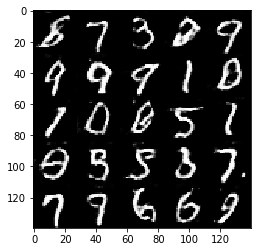

Epoch: 2/2 | Steps: 3510 | Discriminator Loss: 0.8684 | Generator Loss: 1.5939
Epoch: 2/2 | Steps: 3520 | Discriminator Loss: 1.0300 | Generator Loss: 0.9169
Epoch: 2/2 | Steps: 3530 | Discriminator Loss: 0.7788 | Generator Loss: 1.3138
Epoch: 2/2 | Steps: 3540 | Discriminator Loss: 0.9082 | Generator Loss: 1.2427
Epoch: 2/2 | Steps: 3550 | Discriminator Loss: 1.0070 | Generator Loss: 0.7918
Epoch: 2/2 | Steps: 3560 | Discriminator Loss: 0.8468 | Generator Loss: 1.4333
Epoch: 2/2 | Steps: 3570 | Discriminator Loss: 0.8088 | Generator Loss: 1.0062
Epoch: 2/2 | Steps: 3580 | Discriminator Loss: 1.0076 | Generator Loss: 1.3100
Epoch: 2/2 | Steps: 3590 | Discriminator Loss: 0.8421 | Generator Loss: 1.9877
Epoch: 2/2 | Steps: 3600 | Discriminator Loss: 0.8461 | Generator Loss: 1.1673


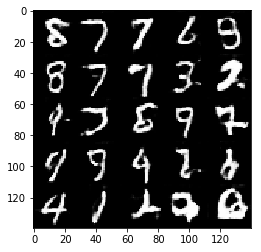

Epoch: 2/2 | Steps: 3610 | Discriminator Loss: 1.1159 | Generator Loss: 1.0220
Epoch: 2/2 | Steps: 3620 | Discriminator Loss: 0.7429 | Generator Loss: 1.5948
Epoch: 2/2 | Steps: 3630 | Discriminator Loss: 0.9732 | Generator Loss: 0.8188
Epoch: 2/2 | Steps: 3640 | Discriminator Loss: 0.8633 | Generator Loss: 1.1760
Epoch: 2/2 | Steps: 3650 | Discriminator Loss: 0.8493 | Generator Loss: 1.9130
Epoch: 2/2 | Steps: 3660 | Discriminator Loss: 0.9602 | Generator Loss: 1.3373
Epoch: 2/2 | Steps: 3670 | Discriminator Loss: 0.8475 | Generator Loss: 1.6211
Epoch: 2/2 | Steps: 3680 | Discriminator Loss: 0.7270 | Generator Loss: 1.6113
Epoch: 2/2 | Steps: 3690 | Discriminator Loss: 0.8382 | Generator Loss: 1.3798
Epoch: 2/2 | Steps: 3700 | Discriminator Loss: 1.2300 | Generator Loss: 1.9021


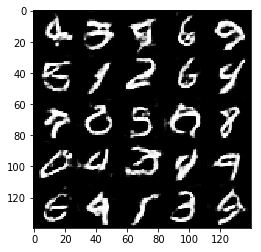

Epoch: 2/2 | Steps: 3710 | Discriminator Loss: 0.9407 | Generator Loss: 1.1271
Epoch: 2/2 | Steps: 3720 | Discriminator Loss: 1.3225 | Generator Loss: 0.7039
Epoch: 2/2 | Steps: 3730 | Discriminator Loss: 0.7843 | Generator Loss: 1.6440
Epoch: 2/2 | Steps: 3740 | Discriminator Loss: 0.8943 | Generator Loss: 1.0197
Epoch: 2/2 | Steps: 3750 | Discriminator Loss: 1.0061 | Generator Loss: 1.7421


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA

Epoch: 1/1 | Steps:   10 | Discriminator Loss: 0.8396 | Generator Loss: 1.4594
Epoch: 1/1 | Steps:   20 | Discriminator Loss: 0.7451 | Generator Loss: 2.0669
Epoch: 1/1 | Steps:   30 | Discriminator Loss: 0.7343 | Generator Loss: 2.0566
Epoch: 1/1 | Steps:   40 | Discriminator Loss: 0.6484 | Generator Loss: 2.5880
Epoch: 1/1 | Steps:   50 | Discriminator Loss: 0.7828 | Generator Loss: 1.9411
Epoch: 1/1 | Steps:   60 | Discriminator Loss: 0.7149 | Generator Loss: 1.9247
Epoch: 1/1 | Steps:   70 | Discriminator Loss: 0.6717 | Generator Loss: 3.6755
Epoch: 1/1 | Steps:   80 | Discriminator Loss: 1.1678 | Generator Loss: 0.7488
Epoch: 1/1 | Steps:   90 | Discriminator Loss: 1.4225 | Generator Loss: 0.7985
Epoch: 1/1 | Steps:  100 | Discriminator Loss: 1.0286 | Generator Loss: 1.5451


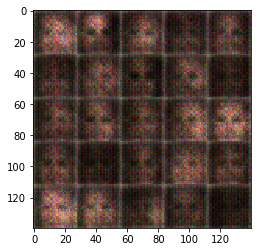

Epoch: 1/1 | Steps:  110 | Discriminator Loss: 1.1056 | Generator Loss: 1.0178
Epoch: 1/1 | Steps:  120 | Discriminator Loss: 0.9084 | Generator Loss: 2.2018
Epoch: 1/1 | Steps:  130 | Discriminator Loss: 0.8344 | Generator Loss: 1.2324
Epoch: 1/1 | Steps:  140 | Discriminator Loss: 0.8539 | Generator Loss: 1.8661
Epoch: 1/1 | Steps:  150 | Discriminator Loss: 0.8697 | Generator Loss: 1.3278
Epoch: 1/1 | Steps:  160 | Discriminator Loss: 1.6143 | Generator Loss: 0.4633
Epoch: 1/1 | Steps:  170 | Discriminator Loss: 1.0249 | Generator Loss: 1.0205
Epoch: 1/1 | Steps:  180 | Discriminator Loss: 0.9096 | Generator Loss: 1.4093
Epoch: 1/1 | Steps:  190 | Discriminator Loss: 1.2074 | Generator Loss: 0.6030
Epoch: 1/1 | Steps:  200 | Discriminator Loss: 1.0528 | Generator Loss: 1.2706


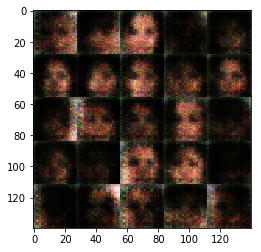

Epoch: 1/1 | Steps:  210 | Discriminator Loss: 1.0045 | Generator Loss: 1.1722
Epoch: 1/1 | Steps:  220 | Discriminator Loss: 1.0600 | Generator Loss: 3.3637
Epoch: 1/1 | Steps:  230 | Discriminator Loss: 1.2595 | Generator Loss: 0.7164
Epoch: 1/1 | Steps:  240 | Discriminator Loss: 1.4365 | Generator Loss: 3.1528
Epoch: 1/1 | Steps:  250 | Discriminator Loss: 1.0385 | Generator Loss: 0.9173
Epoch: 1/1 | Steps:  260 | Discriminator Loss: 0.7920 | Generator Loss: 2.1869
Epoch: 1/1 | Steps:  270 | Discriminator Loss: 1.8111 | Generator Loss: 3.8590
Epoch: 1/1 | Steps:  280 | Discriminator Loss: 1.0574 | Generator Loss: 2.1806
Epoch: 1/1 | Steps:  290 | Discriminator Loss: 1.0212 | Generator Loss: 2.5822
Epoch: 1/1 | Steps:  300 | Discriminator Loss: 1.1667 | Generator Loss: 0.7953


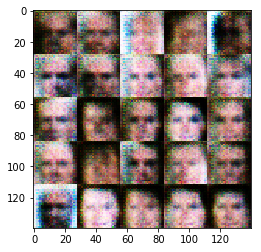

Epoch: 1/1 | Steps:  310 | Discriminator Loss: 0.9659 | Generator Loss: 1.7279
Epoch: 1/1 | Steps:  320 | Discriminator Loss: 1.0390 | Generator Loss: 1.0975
Epoch: 1/1 | Steps:  330 | Discriminator Loss: 0.9063 | Generator Loss: 1.0317
Epoch: 1/1 | Steps:  340 | Discriminator Loss: 0.7992 | Generator Loss: 1.4928
Epoch: 1/1 | Steps:  350 | Discriminator Loss: 0.8101 | Generator Loss: 1.5997
Epoch: 1/1 | Steps:  360 | Discriminator Loss: 1.2712 | Generator Loss: 0.6898
Epoch: 1/1 | Steps:  370 | Discriminator Loss: 1.1180 | Generator Loss: 0.8143
Epoch: 1/1 | Steps:  380 | Discriminator Loss: 1.1798 | Generator Loss: 1.4582
Epoch: 1/1 | Steps:  390 | Discriminator Loss: 0.9600 | Generator Loss: 1.7205
Epoch: 1/1 | Steps:  400 | Discriminator Loss: 0.9769 | Generator Loss: 1.1380


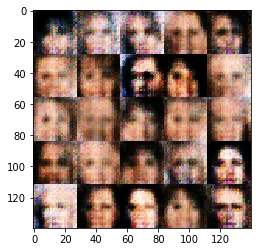

Epoch: 1/1 | Steps:  410 | Discriminator Loss: 0.9023 | Generator Loss: 1.7659
Epoch: 1/1 | Steps:  420 | Discriminator Loss: 1.1381 | Generator Loss: 0.7386
Epoch: 1/1 | Steps:  430 | Discriminator Loss: 0.8014 | Generator Loss: 1.6221
Epoch: 1/1 | Steps:  440 | Discriminator Loss: 1.0835 | Generator Loss: 1.3287
Epoch: 1/1 | Steps:  450 | Discriminator Loss: 0.8737 | Generator Loss: 2.0687
Epoch: 1/1 | Steps:  460 | Discriminator Loss: 0.9979 | Generator Loss: 1.2062
Epoch: 1/1 | Steps:  470 | Discriminator Loss: 1.0229 | Generator Loss: 1.2189
Epoch: 1/1 | Steps:  480 | Discriminator Loss: 1.3792 | Generator Loss: 0.7184
Epoch: 1/1 | Steps:  490 | Discriminator Loss: 1.3492 | Generator Loss: 0.5702
Epoch: 1/1 | Steps:  500 | Discriminator Loss: 0.8587 | Generator Loss: 1.2583


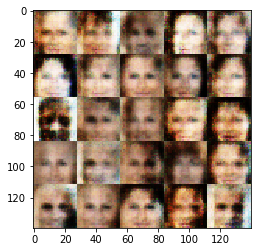

Epoch: 1/1 | Steps:  510 | Discriminator Loss: 1.0250 | Generator Loss: 1.5140
Epoch: 1/1 | Steps:  520 | Discriminator Loss: 1.3487 | Generator Loss: 0.7576
Epoch: 1/1 | Steps:  530 | Discriminator Loss: 1.2197 | Generator Loss: 2.3364
Epoch: 1/1 | Steps:  540 | Discriminator Loss: 1.1752 | Generator Loss: 1.4667
Epoch: 1/1 | Steps:  550 | Discriminator Loss: 1.1505 | Generator Loss: 1.5171
Epoch: 1/1 | Steps:  560 | Discriminator Loss: 1.6240 | Generator Loss: 2.3004
Epoch: 1/1 | Steps:  570 | Discriminator Loss: 1.1181 | Generator Loss: 0.8684
Epoch: 1/1 | Steps:  580 | Discriminator Loss: 1.2401 | Generator Loss: 1.0875
Epoch: 1/1 | Steps:  590 | Discriminator Loss: 1.1233 | Generator Loss: 0.7465
Epoch: 1/1 | Steps:  600 | Discriminator Loss: 1.0656 | Generator Loss: 1.5263


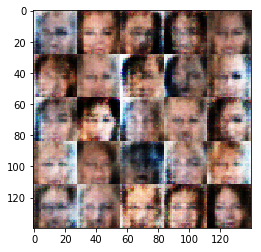

Epoch: 1/1 | Steps:  610 | Discriminator Loss: 1.2558 | Generator Loss: 0.8764
Epoch: 1/1 | Steps:  620 | Discriminator Loss: 1.4671 | Generator Loss: 0.5936
Epoch: 1/1 | Steps:  630 | Discriminator Loss: 1.0623 | Generator Loss: 0.9944
Epoch: 1/1 | Steps:  640 | Discriminator Loss: 1.1325 | Generator Loss: 1.2116
Epoch: 1/1 | Steps:  650 | Discriminator Loss: 1.1450 | Generator Loss: 1.8854
Epoch: 1/1 | Steps:  660 | Discriminator Loss: 1.1278 | Generator Loss: 0.8892
Epoch: 1/1 | Steps:  670 | Discriminator Loss: 1.2031 | Generator Loss: 1.0024
Epoch: 1/1 | Steps:  680 | Discriminator Loss: 1.0477 | Generator Loss: 1.3829
Epoch: 1/1 | Steps:  690 | Discriminator Loss: 1.2240 | Generator Loss: 1.4908
Epoch: 1/1 | Steps:  700 | Discriminator Loss: 1.4405 | Generator Loss: 0.6719


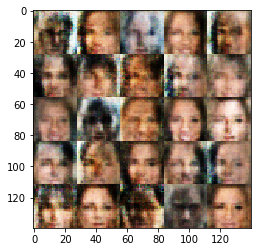

Epoch: 1/1 | Steps:  710 | Discriminator Loss: 1.0125 | Generator Loss: 1.0754
Epoch: 1/1 | Steps:  720 | Discriminator Loss: 1.2173 | Generator Loss: 0.8357
Epoch: 1/1 | Steps:  730 | Discriminator Loss: 0.9842 | Generator Loss: 1.3493
Epoch: 1/1 | Steps:  740 | Discriminator Loss: 1.2527 | Generator Loss: 0.8749
Epoch: 1/1 | Steps:  750 | Discriminator Loss: 0.9992 | Generator Loss: 1.1077
Epoch: 1/1 | Steps:  760 | Discriminator Loss: 1.1544 | Generator Loss: 1.6029
Epoch: 1/1 | Steps:  770 | Discriminator Loss: 1.4441 | Generator Loss: 1.2729
Epoch: 1/1 | Steps:  780 | Discriminator Loss: 1.0936 | Generator Loss: 0.9429
Epoch: 1/1 | Steps:  790 | Discriminator Loss: 1.1532 | Generator Loss: 1.0197
Epoch: 1/1 | Steps:  800 | Discriminator Loss: 1.0936 | Generator Loss: 1.1591


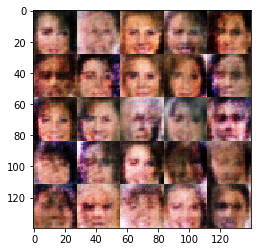

Epoch: 1/1 | Steps:  810 | Discriminator Loss: 1.2120 | Generator Loss: 1.0171
Epoch: 1/1 | Steps:  820 | Discriminator Loss: 1.1084 | Generator Loss: 1.5051
Epoch: 1/1 | Steps:  830 | Discriminator Loss: 1.0887 | Generator Loss: 1.3380
Epoch: 1/1 | Steps:  840 | Discriminator Loss: 1.1010 | Generator Loss: 0.8295
Epoch: 1/1 | Steps:  850 | Discriminator Loss: 1.2129 | Generator Loss: 0.8762
Epoch: 1/1 | Steps:  860 | Discriminator Loss: 1.3578 | Generator Loss: 0.6003
Epoch: 1/1 | Steps:  870 | Discriminator Loss: 1.2475 | Generator Loss: 1.2602
Epoch: 1/1 | Steps:  880 | Discriminator Loss: 1.1522 | Generator Loss: 1.1371
Epoch: 1/1 | Steps:  890 | Discriminator Loss: 1.1640 | Generator Loss: 1.2570
Epoch: 1/1 | Steps:  900 | Discriminator Loss: 1.1373 | Generator Loss: 1.1389


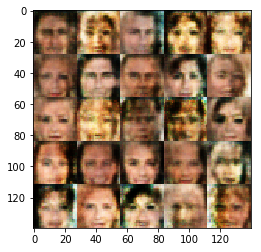

Epoch: 1/1 | Steps:  910 | Discriminator Loss: 1.3408 | Generator Loss: 0.8507
Epoch: 1/1 | Steps:  920 | Discriminator Loss: 1.2309 | Generator Loss: 1.0933
Epoch: 1/1 | Steps:  930 | Discriminator Loss: 1.2344 | Generator Loss: 0.9619
Epoch: 1/1 | Steps:  940 | Discriminator Loss: 1.1704 | Generator Loss: 0.9632
Epoch: 1/1 | Steps:  950 | Discriminator Loss: 1.3185 | Generator Loss: 1.0433
Epoch: 1/1 | Steps:  960 | Discriminator Loss: 1.2230 | Generator Loss: 0.8555
Epoch: 1/1 | Steps:  970 | Discriminator Loss: 1.1298 | Generator Loss: 0.8632
Epoch: 1/1 | Steps:  980 | Discriminator Loss: 1.2727 | Generator Loss: 0.7010
Epoch: 1/1 | Steps:  990 | Discriminator Loss: 1.2516 | Generator Loss: 0.8920
Epoch: 1/1 | Steps: 1000 | Discriminator Loss: 1.1760 | Generator Loss: 1.0956


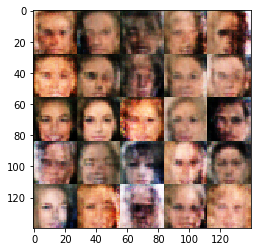

Epoch: 1/1 | Steps: 1010 | Discriminator Loss: 1.2017 | Generator Loss: 0.6799
Epoch: 1/1 | Steps: 1020 | Discriminator Loss: 1.1682 | Generator Loss: 1.0266
Epoch: 1/1 | Steps: 1030 | Discriminator Loss: 1.2723 | Generator Loss: 0.7197
Epoch: 1/1 | Steps: 1040 | Discriminator Loss: 1.3668 | Generator Loss: 0.7889
Epoch: 1/1 | Steps: 1050 | Discriminator Loss: 1.1842 | Generator Loss: 1.0268
Epoch: 1/1 | Steps: 1060 | Discriminator Loss: 1.2052 | Generator Loss: 0.8421
Epoch: 1/1 | Steps: 1070 | Discriminator Loss: 1.2338 | Generator Loss: 1.0989
Epoch: 1/1 | Steps: 1080 | Discriminator Loss: 1.3356 | Generator Loss: 0.9173
Epoch: 1/1 | Steps: 1090 | Discriminator Loss: 1.2787 | Generator Loss: 0.7436
Epoch: 1/1 | Steps: 1100 | Discriminator Loss: 1.0622 | Generator Loss: 1.1194


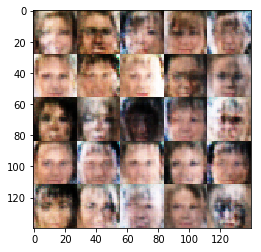

Epoch: 1/1 | Steps: 1110 | Discriminator Loss: 1.2558 | Generator Loss: 1.1433
Epoch: 1/1 | Steps: 1120 | Discriminator Loss: 1.2195 | Generator Loss: 0.7202
Epoch: 1/1 | Steps: 1130 | Discriminator Loss: 1.2240 | Generator Loss: 0.9324
Epoch: 1/1 | Steps: 1140 | Discriminator Loss: 1.1998 | Generator Loss: 0.7381
Epoch: 1/1 | Steps: 1150 | Discriminator Loss: 1.1327 | Generator Loss: 0.8767
Epoch: 1/1 | Steps: 1160 | Discriminator Loss: 1.2732 | Generator Loss: 0.8967
Epoch: 1/1 | Steps: 1170 | Discriminator Loss: 0.9616 | Generator Loss: 1.4207
Epoch: 1/1 | Steps: 1180 | Discriminator Loss: 1.2190 | Generator Loss: 0.7477
Epoch: 1/1 | Steps: 1190 | Discriminator Loss: 1.2540 | Generator Loss: 0.7425
Epoch: 1/1 | Steps: 1200 | Discriminator Loss: 1.2058 | Generator Loss: 0.7495


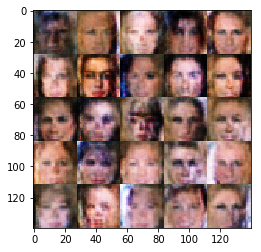

Epoch: 1/1 | Steps: 1210 | Discriminator Loss: 1.2819 | Generator Loss: 0.8361
Epoch: 1/1 | Steps: 1220 | Discriminator Loss: 1.1230 | Generator Loss: 0.9453
Epoch: 1/1 | Steps: 1230 | Discriminator Loss: 1.3331 | Generator Loss: 0.8725
Epoch: 1/1 | Steps: 1240 | Discriminator Loss: 1.2527 | Generator Loss: 0.9538
Epoch: 1/1 | Steps: 1250 | Discriminator Loss: 1.0701 | Generator Loss: 0.9003
Epoch: 1/1 | Steps: 1260 | Discriminator Loss: 1.1275 | Generator Loss: 1.1143
Epoch: 1/1 | Steps: 1270 | Discriminator Loss: 1.2247 | Generator Loss: 0.6980
Epoch: 1/1 | Steps: 1280 | Discriminator Loss: 1.3715 | Generator Loss: 0.5941
Epoch: 1/1 | Steps: 1290 | Discriminator Loss: 1.4255 | Generator Loss: 0.6279
Epoch: 1/1 | Steps: 1300 | Discriminator Loss: 1.1990 | Generator Loss: 0.9635


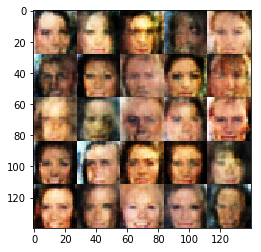

Epoch: 1/1 | Steps: 1310 | Discriminator Loss: 1.3098 | Generator Loss: 1.1692
Epoch: 1/1 | Steps: 1320 | Discriminator Loss: 1.1232 | Generator Loss: 1.5710
Epoch: 1/1 | Steps: 1330 | Discriminator Loss: 1.2317 | Generator Loss: 0.9482
Epoch: 1/1 | Steps: 1340 | Discriminator Loss: 1.1999 | Generator Loss: 0.9347
Epoch: 1/1 | Steps: 1350 | Discriminator Loss: 1.1197 | Generator Loss: 0.9032
Epoch: 1/1 | Steps: 1360 | Discriminator Loss: 1.2076 | Generator Loss: 0.7876
Epoch: 1/1 | Steps: 1370 | Discriminator Loss: 1.0578 | Generator Loss: 1.0952
Epoch: 1/1 | Steps: 1380 | Discriminator Loss: 1.1673 | Generator Loss: 0.9155
Epoch: 1/1 | Steps: 1390 | Discriminator Loss: 1.0591 | Generator Loss: 1.2697
Epoch: 1/1 | Steps: 1400 | Discriminator Loss: 1.1417 | Generator Loss: 0.9264


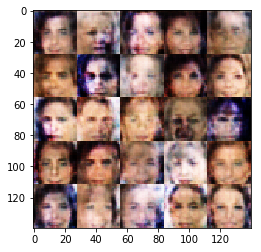

Epoch: 1/1 | Steps: 1410 | Discriminator Loss: 0.9707 | Generator Loss: 1.5016
Epoch: 1/1 | Steps: 1420 | Discriminator Loss: 1.1970 | Generator Loss: 0.9356
Epoch: 1/1 | Steps: 1430 | Discriminator Loss: 1.3483 | Generator Loss: 0.6548
Epoch: 1/1 | Steps: 1440 | Discriminator Loss: 1.2612 | Generator Loss: 0.9495
Epoch: 1/1 | Steps: 1450 | Discriminator Loss: 1.0996 | Generator Loss: 0.9764
Epoch: 1/1 | Steps: 1460 | Discriminator Loss: 1.1755 | Generator Loss: 0.8682
Epoch: 1/1 | Steps: 1470 | Discriminator Loss: 1.2388 | Generator Loss: 0.9291
Epoch: 1/1 | Steps: 1480 | Discriminator Loss: 1.1775 | Generator Loss: 0.9340
Epoch: 1/1 | Steps: 1490 | Discriminator Loss: 1.1962 | Generator Loss: 1.2550
Epoch: 1/1 | Steps: 1500 | Discriminator Loss: 1.3084 | Generator Loss: 1.2019


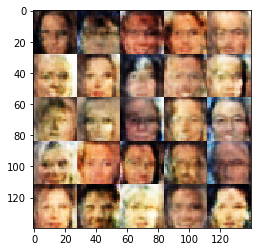

Epoch: 1/1 | Steps: 1510 | Discriminator Loss: 1.0083 | Generator Loss: 1.1513
Epoch: 1/1 | Steps: 1520 | Discriminator Loss: 1.1820 | Generator Loss: 0.7867
Epoch: 1/1 | Steps: 1530 | Discriminator Loss: 1.0672 | Generator Loss: 0.9465
Epoch: 1/1 | Steps: 1540 | Discriminator Loss: 1.1528 | Generator Loss: 1.0137
Epoch: 1/1 | Steps: 1550 | Discriminator Loss: 1.3336 | Generator Loss: 0.8832
Epoch: 1/1 | Steps: 1560 | Discriminator Loss: 1.2636 | Generator Loss: 0.8560
Epoch: 1/1 | Steps: 1570 | Discriminator Loss: 1.1777 | Generator Loss: 0.9765
Epoch: 1/1 | Steps: 1580 | Discriminator Loss: 1.1602 | Generator Loss: 0.7968
Epoch: 1/1 | Steps: 1590 | Discriminator Loss: 1.2886 | Generator Loss: 0.6261
Epoch: 1/1 | Steps: 1600 | Discriminator Loss: 1.3002 | Generator Loss: 0.8905


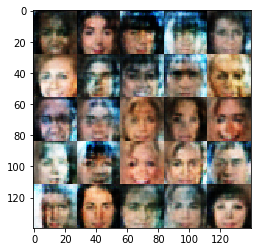

Epoch: 1/1 | Steps: 1610 | Discriminator Loss: 1.2338 | Generator Loss: 0.6545
Epoch: 1/1 | Steps: 1620 | Discriminator Loss: 1.0786 | Generator Loss: 1.2606
Epoch: 1/1 | Steps: 1630 | Discriminator Loss: 1.2211 | Generator Loss: 0.7576
Epoch: 1/1 | Steps: 1640 | Discriminator Loss: 1.1794 | Generator Loss: 0.8307
Epoch: 1/1 | Steps: 1650 | Discriminator Loss: 1.0331 | Generator Loss: 0.9554
Epoch: 1/1 | Steps: 1660 | Discriminator Loss: 1.2954 | Generator Loss: 0.8543
Epoch: 1/1 | Steps: 1670 | Discriminator Loss: 1.1463 | Generator Loss: 0.7405
Epoch: 1/1 | Steps: 1680 | Discriminator Loss: 1.2085 | Generator Loss: 1.0619
Epoch: 1/1 | Steps: 1690 | Discriminator Loss: 1.0967 | Generator Loss: 0.9880
Epoch: 1/1 | Steps: 1700 | Discriminator Loss: 1.1860 | Generator Loss: 0.8745


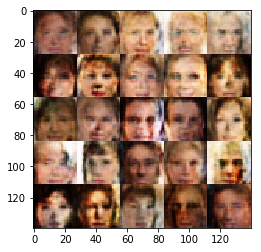

Epoch: 1/1 | Steps: 1710 | Discriminator Loss: 1.1017 | Generator Loss: 1.3963
Epoch: 1/1 | Steps: 1720 | Discriminator Loss: 1.2579 | Generator Loss: 0.8581
Epoch: 1/1 | Steps: 1730 | Discriminator Loss: 1.1136 | Generator Loss: 0.9337
Epoch: 1/1 | Steps: 1740 | Discriminator Loss: 1.1068 | Generator Loss: 0.7985
Epoch: 1/1 | Steps: 1750 | Discriminator Loss: 1.2035 | Generator Loss: 0.7916
Epoch: 1/1 | Steps: 1760 | Discriminator Loss: 1.2851 | Generator Loss: 0.8280
Epoch: 1/1 | Steps: 1770 | Discriminator Loss: 1.3243 | Generator Loss: 0.9431
Epoch: 1/1 | Steps: 1780 | Discriminator Loss: 1.2255 | Generator Loss: 0.8921
Epoch: 1/1 | Steps: 1790 | Discriminator Loss: 1.3842 | Generator Loss: 1.5278
Epoch: 1/1 | Steps: 1800 | Discriminator Loss: 1.1246 | Generator Loss: 1.1185


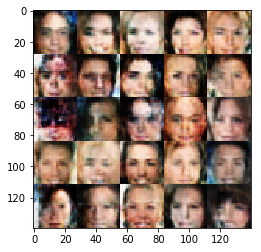

Epoch: 1/1 | Steps: 1810 | Discriminator Loss: 1.1151 | Generator Loss: 1.0883
Epoch: 1/1 | Steps: 1820 | Discriminator Loss: 1.2217 | Generator Loss: 0.9495
Epoch: 1/1 | Steps: 1830 | Discriminator Loss: 1.3340 | Generator Loss: 1.0713
Epoch: 1/1 | Steps: 1840 | Discriminator Loss: 1.1289 | Generator Loss: 0.9672
Epoch: 1/1 | Steps: 1850 | Discriminator Loss: 1.1974 | Generator Loss: 0.8835
Epoch: 1/1 | Steps: 1860 | Discriminator Loss: 1.1048 | Generator Loss: 1.0621
Epoch: 1/1 | Steps: 1870 | Discriminator Loss: 1.2648 | Generator Loss: 0.6668
Epoch: 1/1 | Steps: 1880 | Discriminator Loss: 1.1952 | Generator Loss: 1.0951
Epoch: 1/1 | Steps: 1890 | Discriminator Loss: 1.2083 | Generator Loss: 0.7488
Epoch: 1/1 | Steps: 1900 | Discriminator Loss: 1.3580 | Generator Loss: 0.6624


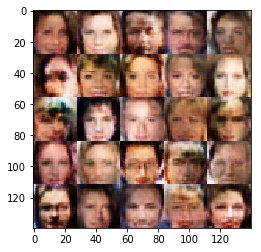

Epoch: 1/1 | Steps: 1910 | Discriminator Loss: 1.1891 | Generator Loss: 1.1623
Epoch: 1/1 | Steps: 1920 | Discriminator Loss: 1.1508 | Generator Loss: 1.1633
Epoch: 1/1 | Steps: 1930 | Discriminator Loss: 1.2947 | Generator Loss: 0.6497
Epoch: 1/1 | Steps: 1940 | Discriminator Loss: 1.1230 | Generator Loss: 0.8929
Epoch: 1/1 | Steps: 1950 | Discriminator Loss: 1.2238 | Generator Loss: 0.8799
Epoch: 1/1 | Steps: 1960 | Discriminator Loss: 1.2741 | Generator Loss: 0.7679
Epoch: 1/1 | Steps: 1970 | Discriminator Loss: 1.4580 | Generator Loss: 0.5232
Epoch: 1/1 | Steps: 1980 | Discriminator Loss: 1.2075 | Generator Loss: 0.9308
Epoch: 1/1 | Steps: 1990 | Discriminator Loss: 1.1406 | Generator Loss: 0.8988
Epoch: 1/1 | Steps: 2000 | Discriminator Loss: 1.3974 | Generator Loss: 0.6951


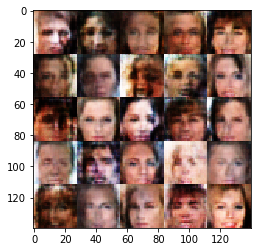

Epoch: 1/1 | Steps: 2010 | Discriminator Loss: 1.3355 | Generator Loss: 0.7500
Epoch: 1/1 | Steps: 2020 | Discriminator Loss: 1.2400 | Generator Loss: 0.6674
Epoch: 1/1 | Steps: 2030 | Discriminator Loss: 1.1651 | Generator Loss: 0.9368
Epoch: 1/1 | Steps: 2040 | Discriminator Loss: 1.3998 | Generator Loss: 0.7229
Epoch: 1/1 | Steps: 2050 | Discriminator Loss: 1.2705 | Generator Loss: 0.9035
Epoch: 1/1 | Steps: 2060 | Discriminator Loss: 1.1224 | Generator Loss: 1.0614
Epoch: 1/1 | Steps: 2070 | Discriminator Loss: 1.2248 | Generator Loss: 0.8439
Epoch: 1/1 | Steps: 2080 | Discriminator Loss: 1.1073 | Generator Loss: 0.9567
Epoch: 1/1 | Steps: 2090 | Discriminator Loss: 1.3273 | Generator Loss: 0.8424
Epoch: 1/1 | Steps: 2100 | Discriminator Loss: 1.1946 | Generator Loss: 0.8357


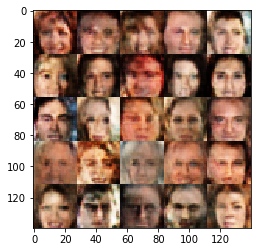

Epoch: 1/1 | Steps: 2110 | Discriminator Loss: 1.1261 | Generator Loss: 1.0902
Epoch: 1/1 | Steps: 2120 | Discriminator Loss: 1.1879 | Generator Loss: 0.7758
Epoch: 1/1 | Steps: 2130 | Discriminator Loss: 1.1936 | Generator Loss: 1.2502
Epoch: 1/1 | Steps: 2140 | Discriminator Loss: 1.1219 | Generator Loss: 0.8612
Epoch: 1/1 | Steps: 2150 | Discriminator Loss: 1.3696 | Generator Loss: 0.6569
Epoch: 1/1 | Steps: 2160 | Discriminator Loss: 1.2040 | Generator Loss: 0.9164
Epoch: 1/1 | Steps: 2170 | Discriminator Loss: 1.1174 | Generator Loss: 0.8258
Epoch: 1/1 | Steps: 2180 | Discriminator Loss: 1.1220 | Generator Loss: 1.1734
Epoch: 1/1 | Steps: 2190 | Discriminator Loss: 1.1487 | Generator Loss: 0.8289
Epoch: 1/1 | Steps: 2200 | Discriminator Loss: 1.1510 | Generator Loss: 1.1319


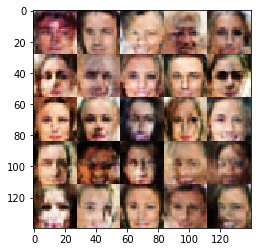

Epoch: 1/1 | Steps: 2210 | Discriminator Loss: 1.2922 | Generator Loss: 0.6680
Epoch: 1/1 | Steps: 2220 | Discriminator Loss: 1.2822 | Generator Loss: 0.7049
Epoch: 1/1 | Steps: 2230 | Discriminator Loss: 1.3222 | Generator Loss: 0.5933
Epoch: 1/1 | Steps: 2240 | Discriminator Loss: 1.1971 | Generator Loss: 1.0744
Epoch: 1/1 | Steps: 2250 | Discriminator Loss: 1.1830 | Generator Loss: 0.9566
Epoch: 1/1 | Steps: 2260 | Discriminator Loss: 1.1580 | Generator Loss: 0.8061
Epoch: 1/1 | Steps: 2270 | Discriminator Loss: 1.1387 | Generator Loss: 0.8361
Epoch: 1/1 | Steps: 2280 | Discriminator Loss: 1.2828 | Generator Loss: 0.6052
Epoch: 1/1 | Steps: 2290 | Discriminator Loss: 1.1523 | Generator Loss: 0.8604
Epoch: 1/1 | Steps: 2300 | Discriminator Loss: 1.2171 | Generator Loss: 1.1142


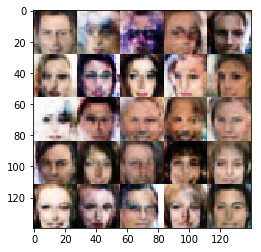

Epoch: 1/1 | Steps: 2310 | Discriminator Loss: 1.1207 | Generator Loss: 0.8927
Epoch: 1/1 | Steps: 2320 | Discriminator Loss: 1.2173 | Generator Loss: 0.9757
Epoch: 1/1 | Steps: 2330 | Discriminator Loss: 1.4685 | Generator Loss: 0.5581
Epoch: 1/1 | Steps: 2340 | Discriminator Loss: 1.2544 | Generator Loss: 1.0065
Epoch: 1/1 | Steps: 2350 | Discriminator Loss: 1.0622 | Generator Loss: 0.8934
Epoch: 1/1 | Steps: 2360 | Discriminator Loss: 1.3201 | Generator Loss: 0.6243
Epoch: 1/1 | Steps: 2370 | Discriminator Loss: 1.0995 | Generator Loss: 1.0668
Epoch: 1/1 | Steps: 2380 | Discriminator Loss: 1.2157 | Generator Loss: 0.6534
Epoch: 1/1 | Steps: 2390 | Discriminator Loss: 1.2167 | Generator Loss: 0.9857
Epoch: 1/1 | Steps: 2400 | Discriminator Loss: 1.2101 | Generator Loss: 0.8915


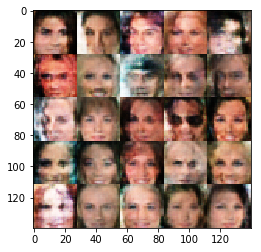

Epoch: 1/1 | Steps: 2410 | Discriminator Loss: 1.1787 | Generator Loss: 0.7407
Epoch: 1/1 | Steps: 2420 | Discriminator Loss: 1.2519 | Generator Loss: 0.9245
Epoch: 1/1 | Steps: 2430 | Discriminator Loss: 1.1992 | Generator Loss: 0.9770
Epoch: 1/1 | Steps: 2440 | Discriminator Loss: 1.0920 | Generator Loss: 1.1827
Epoch: 1/1 | Steps: 2450 | Discriminator Loss: 1.2884 | Generator Loss: 0.9855
Epoch: 1/1 | Steps: 2460 | Discriminator Loss: 1.1905 | Generator Loss: 0.9513
Epoch: 1/1 | Steps: 2470 | Discriminator Loss: 1.2292 | Generator Loss: 0.8598
Epoch: 1/1 | Steps: 2480 | Discriminator Loss: 1.1512 | Generator Loss: 0.7842
Epoch: 1/1 | Steps: 2490 | Discriminator Loss: 1.2220 | Generator Loss: 0.7762
Epoch: 1/1 | Steps: 2500 | Discriminator Loss: 1.1213 | Generator Loss: 0.9102


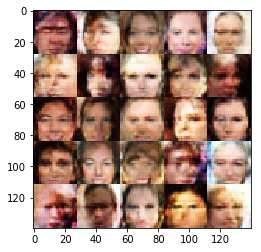

Epoch: 1/1 | Steps: 2510 | Discriminator Loss: 1.1917 | Generator Loss: 0.7662
Epoch: 1/1 | Steps: 2520 | Discriminator Loss: 1.1471 | Generator Loss: 0.7307
Epoch: 1/1 | Steps: 2530 | Discriminator Loss: 1.2442 | Generator Loss: 0.9948
Epoch: 1/1 | Steps: 2540 | Discriminator Loss: 1.1562 | Generator Loss: 0.6944
Epoch: 1/1 | Steps: 2550 | Discriminator Loss: 1.1157 | Generator Loss: 0.9037
Epoch: 1/1 | Steps: 2560 | Discriminator Loss: 1.3138 | Generator Loss: 0.9088
Epoch: 1/1 | Steps: 2570 | Discriminator Loss: 1.0052 | Generator Loss: 1.4078
Epoch: 1/1 | Steps: 2580 | Discriminator Loss: 1.1746 | Generator Loss: 0.7770
Epoch: 1/1 | Steps: 2590 | Discriminator Loss: 1.0462 | Generator Loss: 1.0890
Epoch: 1/1 | Steps: 2600 | Discriminator Loss: 1.0871 | Generator Loss: 1.0968


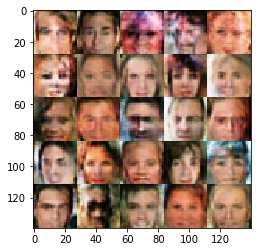

Epoch: 1/1 | Steps: 2610 | Discriminator Loss: 1.2990 | Generator Loss: 0.8462
Epoch: 1/1 | Steps: 2620 | Discriminator Loss: 1.1867 | Generator Loss: 0.8636
Epoch: 1/1 | Steps: 2630 | Discriminator Loss: 1.2263 | Generator Loss: 0.8208
Epoch: 1/1 | Steps: 2640 | Discriminator Loss: 1.0222 | Generator Loss: 1.3734
Epoch: 1/1 | Steps: 2650 | Discriminator Loss: 1.3693 | Generator Loss: 0.6748
Epoch: 1/1 | Steps: 2660 | Discriminator Loss: 1.0995 | Generator Loss: 0.9600
Epoch: 1/1 | Steps: 2670 | Discriminator Loss: 1.1617 | Generator Loss: 0.7399
Epoch: 1/1 | Steps: 2680 | Discriminator Loss: 1.2166 | Generator Loss: 0.7455
Epoch: 1/1 | Steps: 2690 | Discriminator Loss: 1.1405 | Generator Loss: 0.8663
Epoch: 1/1 | Steps: 2700 | Discriminator Loss: 1.1359 | Generator Loss: 0.8742


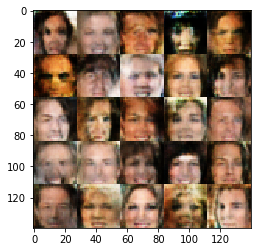

Epoch: 1/1 | Steps: 2710 | Discriminator Loss: 1.2581 | Generator Loss: 0.7799
Epoch: 1/1 | Steps: 2720 | Discriminator Loss: 1.2633 | Generator Loss: 0.6801
Epoch: 1/1 | Steps: 2730 | Discriminator Loss: 1.2758 | Generator Loss: 0.8063
Epoch: 1/1 | Steps: 2740 | Discriminator Loss: 1.1850 | Generator Loss: 0.6295
Epoch: 1/1 | Steps: 2750 | Discriminator Loss: 1.0826 | Generator Loss: 0.9939
Epoch: 1/1 | Steps: 2760 | Discriminator Loss: 1.2557 | Generator Loss: 0.9141
Epoch: 1/1 | Steps: 2770 | Discriminator Loss: 1.1370 | Generator Loss: 0.9194
Epoch: 1/1 | Steps: 2780 | Discriminator Loss: 1.2330 | Generator Loss: 0.7640
Epoch: 1/1 | Steps: 2790 | Discriminator Loss: 1.1541 | Generator Loss: 0.7040
Epoch: 1/1 | Steps: 2800 | Discriminator Loss: 1.2613 | Generator Loss: 0.7996


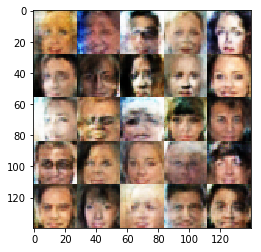

Epoch: 1/1 | Steps: 2810 | Discriminator Loss: 1.1482 | Generator Loss: 0.9393
Epoch: 1/1 | Steps: 2820 | Discriminator Loss: 1.2171 | Generator Loss: 1.0577
Epoch: 1/1 | Steps: 2830 | Discriminator Loss: 1.4500 | Generator Loss: 0.4223
Epoch: 1/1 | Steps: 2840 | Discriminator Loss: 1.1289 | Generator Loss: 0.8457
Epoch: 1/1 | Steps: 2850 | Discriminator Loss: 1.0935 | Generator Loss: 0.8362
Epoch: 1/1 | Steps: 2860 | Discriminator Loss: 1.1837 | Generator Loss: 0.8071
Epoch: 1/1 | Steps: 2870 | Discriminator Loss: 1.1883 | Generator Loss: 0.9465
Epoch: 1/1 | Steps: 2880 | Discriminator Loss: 1.1662 | Generator Loss: 1.1699
Epoch: 1/1 | Steps: 2890 | Discriminator Loss: 1.3410 | Generator Loss: 0.5797
Epoch: 1/1 | Steps: 2900 | Discriminator Loss: 1.2147 | Generator Loss: 1.0676


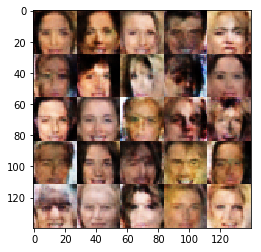

Epoch: 1/1 | Steps: 2910 | Discriminator Loss: 1.2286 | Generator Loss: 0.8670
Epoch: 1/1 | Steps: 2920 | Discriminator Loss: 1.2513 | Generator Loss: 0.7117
Epoch: 1/1 | Steps: 2930 | Discriminator Loss: 1.1845 | Generator Loss: 1.0454
Epoch: 1/1 | Steps: 2940 | Discriminator Loss: 1.1032 | Generator Loss: 0.9239
Epoch: 1/1 | Steps: 2950 | Discriminator Loss: 1.1529 | Generator Loss: 0.7846
Epoch: 1/1 | Steps: 2960 | Discriminator Loss: 1.0279 | Generator Loss: 1.0914
Epoch: 1/1 | Steps: 2970 | Discriminator Loss: 1.1554 | Generator Loss: 0.8894
Epoch: 1/1 | Steps: 2980 | Discriminator Loss: 1.3179 | Generator Loss: 0.8061
Epoch: 1/1 | Steps: 2990 | Discriminator Loss: 1.1530 | Generator Loss: 0.9671
Epoch: 1/1 | Steps: 3000 | Discriminator Loss: 1.1198 | Generator Loss: 0.8518


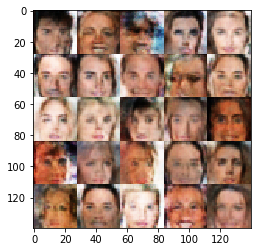

Epoch: 1/1 | Steps: 3010 | Discriminator Loss: 1.1025 | Generator Loss: 1.2373
Epoch: 1/1 | Steps: 3020 | Discriminator Loss: 1.2298 | Generator Loss: 0.8729
Epoch: 1/1 | Steps: 3030 | Discriminator Loss: 1.1868 | Generator Loss: 0.8929
Epoch: 1/1 | Steps: 3040 | Discriminator Loss: 1.2991 | Generator Loss: 0.5869
Epoch: 1/1 | Steps: 3050 | Discriminator Loss: 1.2411 | Generator Loss: 0.9864
Epoch: 1/1 | Steps: 3060 | Discriminator Loss: 0.9755 | Generator Loss: 1.2196
Epoch: 1/1 | Steps: 3070 | Discriminator Loss: 1.4834 | Generator Loss: 0.5502
Epoch: 1/1 | Steps: 3080 | Discriminator Loss: 1.1913 | Generator Loss: 1.0708
Epoch: 1/1 | Steps: 3090 | Discriminator Loss: 1.1852 | Generator Loss: 0.8542
Epoch: 1/1 | Steps: 3100 | Discriminator Loss: 1.3405 | Generator Loss: 0.5879


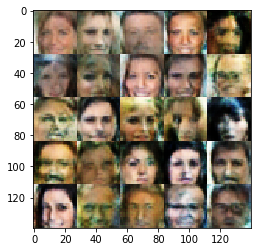

Epoch: 1/1 | Steps: 3110 | Discriminator Loss: 1.0492 | Generator Loss: 1.0368
Epoch: 1/1 | Steps: 3120 | Discriminator Loss: 1.1057 | Generator Loss: 0.9173
Epoch: 1/1 | Steps: 3130 | Discriminator Loss: 1.1625 | Generator Loss: 0.8128
Epoch: 1/1 | Steps: 3140 | Discriminator Loss: 1.2585 | Generator Loss: 0.6948
Epoch: 1/1 | Steps: 3150 | Discriminator Loss: 0.9559 | Generator Loss: 1.2509
Epoch: 1/1 | Steps: 3160 | Discriminator Loss: 1.1670 | Generator Loss: 1.0354
Epoch: 1/1 | Steps: 3170 | Discriminator Loss: 1.3898 | Generator Loss: 0.8112
Epoch: 1/1 | Steps: 3180 | Discriminator Loss: 1.2596 | Generator Loss: 0.6974
Epoch: 1/1 | Steps: 3190 | Discriminator Loss: 1.0945 | Generator Loss: 0.8946
Epoch: 1/1 | Steps: 3200 | Discriminator Loss: 1.1090 | Generator Loss: 1.2317


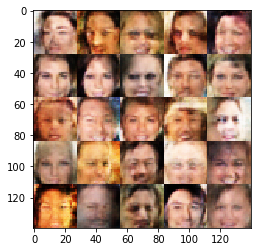

Epoch: 1/1 | Steps: 3210 | Discriminator Loss: 1.0896 | Generator Loss: 1.1809
Epoch: 1/1 | Steps: 3220 | Discriminator Loss: 1.0698 | Generator Loss: 0.7579
Epoch: 1/1 | Steps: 3230 | Discriminator Loss: 1.1284 | Generator Loss: 0.8539
Epoch: 1/1 | Steps: 3240 | Discriminator Loss: 1.2632 | Generator Loss: 0.8406
Epoch: 1/1 | Steps: 3250 | Discriminator Loss: 1.5441 | Generator Loss: 0.4074
Epoch: 1/1 | Steps: 3260 | Discriminator Loss: 1.3276 | Generator Loss: 0.7019
Epoch: 1/1 | Steps: 3270 | Discriminator Loss: 1.3147 | Generator Loss: 0.8901
Epoch: 1/1 | Steps: 3280 | Discriminator Loss: 1.0990 | Generator Loss: 0.8764
Epoch: 1/1 | Steps: 3290 | Discriminator Loss: 1.3537 | Generator Loss: 0.8167
Epoch: 1/1 | Steps: 3300 | Discriminator Loss: 1.1449 | Generator Loss: 1.3621


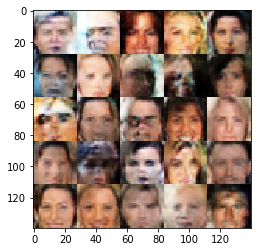

Epoch: 1/1 | Steps: 3310 | Discriminator Loss: 1.0610 | Generator Loss: 1.1405
Epoch: 1/1 | Steps: 3320 | Discriminator Loss: 1.0434 | Generator Loss: 0.9750
Epoch: 1/1 | Steps: 3330 | Discriminator Loss: 1.0218 | Generator Loss: 1.2156
Epoch: 1/1 | Steps: 3340 | Discriminator Loss: 0.9943 | Generator Loss: 0.9484
Epoch: 1/1 | Steps: 3350 | Discriminator Loss: 1.0287 | Generator Loss: 1.0107
Epoch: 1/1 | Steps: 3360 | Discriminator Loss: 1.1265 | Generator Loss: 0.8078
Epoch: 1/1 | Steps: 3370 | Discriminator Loss: 1.2199 | Generator Loss: 0.8661
Epoch: 1/1 | Steps: 3380 | Discriminator Loss: 1.1790 | Generator Loss: 0.9907
Epoch: 1/1 | Steps: 3390 | Discriminator Loss: 1.2897 | Generator Loss: 0.9740
Epoch: 1/1 | Steps: 3400 | Discriminator Loss: 1.2706 | Generator Loss: 0.7134


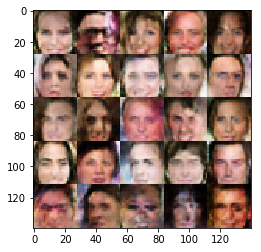

Epoch: 1/1 | Steps: 3410 | Discriminator Loss: 1.2240 | Generator Loss: 0.9791
Epoch: 1/1 | Steps: 3420 | Discriminator Loss: 1.1502 | Generator Loss: 0.8337
Epoch: 1/1 | Steps: 3430 | Discriminator Loss: 1.1576 | Generator Loss: 0.8816
Epoch: 1/1 | Steps: 3440 | Discriminator Loss: 0.9929 | Generator Loss: 1.0709
Epoch: 1/1 | Steps: 3450 | Discriminator Loss: 1.2916 | Generator Loss: 0.6932
Epoch: 1/1 | Steps: 3460 | Discriminator Loss: 1.1080 | Generator Loss: 1.0609
Epoch: 1/1 | Steps: 3470 | Discriminator Loss: 1.0247 | Generator Loss: 1.1487
Epoch: 1/1 | Steps: 3480 | Discriminator Loss: 1.0619 | Generator Loss: 0.9975
Epoch: 1/1 | Steps: 3490 | Discriminator Loss: 1.5119 | Generator Loss: 0.6629
Epoch: 1/1 | Steps: 3500 | Discriminator Loss: 1.0848 | Generator Loss: 0.8426


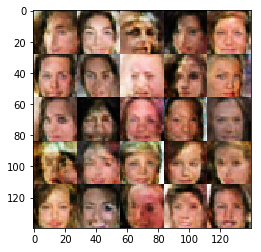

Epoch: 1/1 | Steps: 3510 | Discriminator Loss: 1.3461 | Generator Loss: 0.6344
Epoch: 1/1 | Steps: 3520 | Discriminator Loss: 1.2910 | Generator Loss: 0.6858
Epoch: 1/1 | Steps: 3530 | Discriminator Loss: 1.1402 | Generator Loss: 1.0269
Epoch: 1/1 | Steps: 3540 | Discriminator Loss: 1.1507 | Generator Loss: 0.7402
Epoch: 1/1 | Steps: 3550 | Discriminator Loss: 1.0554 | Generator Loss: 1.3091
Epoch: 1/1 | Steps: 3560 | Discriminator Loss: 1.0957 | Generator Loss: 0.9787
Epoch: 1/1 | Steps: 3570 | Discriminator Loss: 1.2618 | Generator Loss: 0.7736
Epoch: 1/1 | Steps: 3580 | Discriminator Loss: 1.1197 | Generator Loss: 0.9892
Epoch: 1/1 | Steps: 3590 | Discriminator Loss: 1.0405 | Generator Loss: 1.1453
Epoch: 1/1 | Steps: 3600 | Discriminator Loss: 1.1410 | Generator Loss: 0.9780


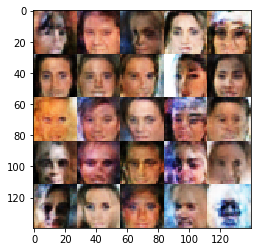

Epoch: 1/1 | Steps: 3610 | Discriminator Loss: 0.9299 | Generator Loss: 1.4962
Epoch: 1/1 | Steps: 3620 | Discriminator Loss: 1.3771 | Generator Loss: 0.8911
Epoch: 1/1 | Steps: 3630 | Discriminator Loss: 1.2429 | Generator Loss: 0.8176
Epoch: 1/1 | Steps: 3640 | Discriminator Loss: 1.2095 | Generator Loss: 0.8085
Epoch: 1/1 | Steps: 3650 | Discriminator Loss: 1.0853 | Generator Loss: 1.1046
Epoch: 1/1 | Steps: 3660 | Discriminator Loss: 1.1915 | Generator Loss: 0.6803
Epoch: 1/1 | Steps: 3670 | Discriminator Loss: 1.0596 | Generator Loss: 1.0727
Epoch: 1/1 | Steps: 3680 | Discriminator Loss: 1.2218 | Generator Loss: 0.8244
Epoch: 1/1 | Steps: 3690 | Discriminator Loss: 1.0765 | Generator Loss: 0.8917
Epoch: 1/1 | Steps: 3700 | Discriminator Loss: 1.1506 | Generator Loss: 0.6805


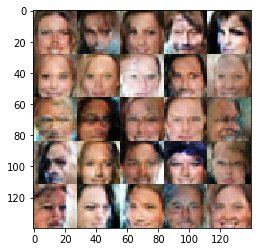

Epoch: 1/1 | Steps: 3710 | Discriminator Loss: 1.1682 | Generator Loss: 1.0227
Epoch: 1/1 | Steps: 3720 | Discriminator Loss: 1.0207 | Generator Loss: 1.3697
Epoch: 1/1 | Steps: 3730 | Discriminator Loss: 1.4084 | Generator Loss: 0.5419
Epoch: 1/1 | Steps: 3740 | Discriminator Loss: 1.2268 | Generator Loss: 0.7418
Epoch: 1/1 | Steps: 3750 | Discriminator Loss: 1.2700 | Generator Loss: 1.1773
Epoch: 1/1 | Steps: 3760 | Discriminator Loss: 1.2670 | Generator Loss: 0.6298
Epoch: 1/1 | Steps: 3770 | Discriminator Loss: 1.3076 | Generator Loss: 0.8183
Epoch: 1/1 | Steps: 3780 | Discriminator Loss: 1.1485 | Generator Loss: 0.7663
Epoch: 1/1 | Steps: 3790 | Discriminator Loss: 1.2802 | Generator Loss: 0.5714
Epoch: 1/1 | Steps: 3800 | Discriminator Loss: 1.1561 | Generator Loss: 0.9964


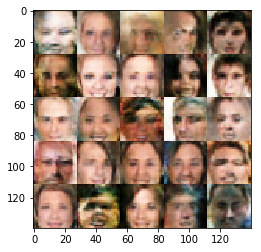

Epoch: 1/1 | Steps: 3810 | Discriminator Loss: 1.0998 | Generator Loss: 0.8959
Epoch: 1/1 | Steps: 3820 | Discriminator Loss: 1.2554 | Generator Loss: 0.6335
Epoch: 1/1 | Steps: 3830 | Discriminator Loss: 1.2118 | Generator Loss: 0.8165
Epoch: 1/1 | Steps: 3840 | Discriminator Loss: 1.0714 | Generator Loss: 1.3072
Epoch: 1/1 | Steps: 3850 | Discriminator Loss: 1.3416 | Generator Loss: 0.6546
Epoch: 1/1 | Steps: 3860 | Discriminator Loss: 1.1424 | Generator Loss: 1.1621
Epoch: 1/1 | Steps: 3870 | Discriminator Loss: 1.1756 | Generator Loss: 0.8023
Epoch: 1/1 | Steps: 3880 | Discriminator Loss: 1.3812 | Generator Loss: 0.6306
Epoch: 1/1 | Steps: 3890 | Discriminator Loss: 1.0341 | Generator Loss: 0.9356
Epoch: 1/1 | Steps: 3900 | Discriminator Loss: 1.1608 | Generator Loss: 0.7065


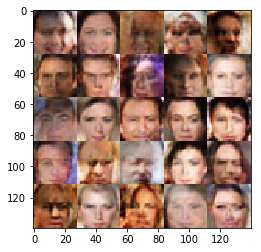

Epoch: 1/1 | Steps: 3910 | Discriminator Loss: 1.0710 | Generator Loss: 0.8943
Epoch: 1/1 | Steps: 3920 | Discriminator Loss: 1.0439 | Generator Loss: 1.0673
Epoch: 1/1 | Steps: 3930 | Discriminator Loss: 1.1489 | Generator Loss: 1.1044
Epoch: 1/1 | Steps: 3940 | Discriminator Loss: 1.2668 | Generator Loss: 0.7967
Epoch: 1/1 | Steps: 3950 | Discriminator Loss: 1.1043 | Generator Loss: 0.8952
Epoch: 1/1 | Steps: 3960 | Discriminator Loss: 1.3400 | Generator Loss: 0.6078
Epoch: 1/1 | Steps: 3970 | Discriminator Loss: 1.1550 | Generator Loss: 0.9339
Epoch: 1/1 | Steps: 3980 | Discriminator Loss: 1.1545 | Generator Loss: 0.7677
Epoch: 1/1 | Steps: 3990 | Discriminator Loss: 0.9642 | Generator Loss: 1.3715
Epoch: 1/1 | Steps: 4000 | Discriminator Loss: 0.9183 | Generator Loss: 1.1357


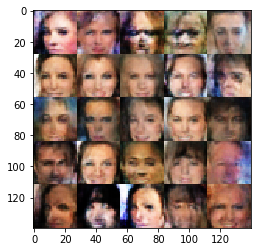

Epoch: 1/1 | Steps: 4010 | Discriminator Loss: 1.0520 | Generator Loss: 0.9854
Epoch: 1/1 | Steps: 4020 | Discriminator Loss: 1.3277 | Generator Loss: 1.2335
Epoch: 1/1 | Steps: 4030 | Discriminator Loss: 1.1367 | Generator Loss: 0.9546
Epoch: 1/1 | Steps: 4040 | Discriminator Loss: 1.1988 | Generator Loss: 1.3199
Epoch: 1/1 | Steps: 4050 | Discriminator Loss: 1.1064 | Generator Loss: 0.8471
Epoch: 1/1 | Steps: 4060 | Discriminator Loss: 1.1229 | Generator Loss: 0.7772
Epoch: 1/1 | Steps: 4070 | Discriminator Loss: 1.3407 | Generator Loss: 0.7058
Epoch: 1/1 | Steps: 4080 | Discriminator Loss: 0.9401 | Generator Loss: 1.2943
Epoch: 1/1 | Steps: 4090 | Discriminator Loss: 1.1544 | Generator Loss: 0.6977
Epoch: 1/1 | Steps: 4100 | Discriminator Loss: 1.2108 | Generator Loss: 0.7267


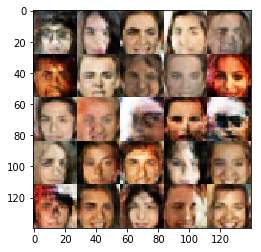

Epoch: 1/1 | Steps: 4110 | Discriminator Loss: 1.1923 | Generator Loss: 0.8048
Epoch: 1/1 | Steps: 4120 | Discriminator Loss: 1.0514 | Generator Loss: 1.0323
Epoch: 1/1 | Steps: 4130 | Discriminator Loss: 1.2862 | Generator Loss: 1.0465
Epoch: 1/1 | Steps: 4140 | Discriminator Loss: 1.1063 | Generator Loss: 0.7858
Epoch: 1/1 | Steps: 4150 | Discriminator Loss: 1.2281 | Generator Loss: 0.9401
Epoch: 1/1 | Steps: 4160 | Discriminator Loss: 1.2309 | Generator Loss: 0.8177
Epoch: 1/1 | Steps: 4170 | Discriminator Loss: 1.3107 | Generator Loss: 0.8958
Epoch: 1/1 | Steps: 4180 | Discriminator Loss: 1.3995 | Generator Loss: 0.6970
Epoch: 1/1 | Steps: 4190 | Discriminator Loss: 1.2826 | Generator Loss: 0.7111
Epoch: 1/1 | Steps: 4200 | Discriminator Loss: 1.2130 | Generator Loss: 0.7324


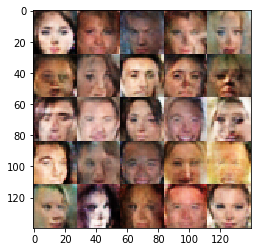

Epoch: 1/1 | Steps: 4210 | Discriminator Loss: 1.2646 | Generator Loss: 0.7489
Epoch: 1/1 | Steps: 4220 | Discriminator Loss: 1.1211 | Generator Loss: 0.9958
Epoch: 1/1 | Steps: 4230 | Discriminator Loss: 1.2327 | Generator Loss: 0.6100
Epoch: 1/1 | Steps: 4240 | Discriminator Loss: 1.1072 | Generator Loss: 1.0527
Epoch: 1/1 | Steps: 4250 | Discriminator Loss: 1.4104 | Generator Loss: 0.6012
Epoch: 1/1 | Steps: 4260 | Discriminator Loss: 1.1665 | Generator Loss: 0.8333
Epoch: 1/1 | Steps: 4270 | Discriminator Loss: 1.2921 | Generator Loss: 0.6840
Epoch: 1/1 | Steps: 4280 | Discriminator Loss: 1.0373 | Generator Loss: 1.0817
Epoch: 1/1 | Steps: 4290 | Discriminator Loss: 1.3011 | Generator Loss: 0.7932
Epoch: 1/1 | Steps: 4300 | Discriminator Loss: 1.2392 | Generator Loss: 0.8710


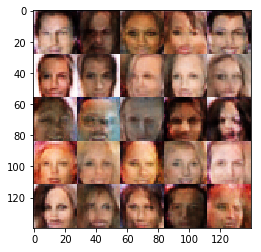

Epoch: 1/1 | Steps: 4310 | Discriminator Loss: 0.9606 | Generator Loss: 1.4118
Epoch: 1/1 | Steps: 4320 | Discriminator Loss: 1.4231 | Generator Loss: 0.5288
Epoch: 1/1 | Steps: 4330 | Discriminator Loss: 1.2509 | Generator Loss: 0.6304
Epoch: 1/1 | Steps: 4340 | Discriminator Loss: 1.1558 | Generator Loss: 0.7361
Epoch: 1/1 | Steps: 4350 | Discriminator Loss: 1.1148 | Generator Loss: 0.9833
Epoch: 1/1 | Steps: 4360 | Discriminator Loss: 1.2146 | Generator Loss: 0.7329
Epoch: 1/1 | Steps: 4370 | Discriminator Loss: 1.1901 | Generator Loss: 1.1984
Epoch: 1/1 | Steps: 4380 | Discriminator Loss: 1.1612 | Generator Loss: 0.8869
Epoch: 1/1 | Steps: 4390 | Discriminator Loss: 1.2278 | Generator Loss: 1.1432
Epoch: 1/1 | Steps: 4400 | Discriminator Loss: 1.1388 | Generator Loss: 0.9281


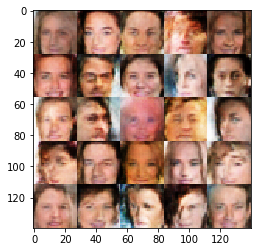

Epoch: 1/1 | Steps: 4410 | Discriminator Loss: 1.2581 | Generator Loss: 0.7809
Epoch: 1/1 | Steps: 4420 | Discriminator Loss: 1.0779 | Generator Loss: 0.8814
Epoch: 1/1 | Steps: 4430 | Discriminator Loss: 1.1592 | Generator Loss: 1.0254
Epoch: 1/1 | Steps: 4440 | Discriminator Loss: 1.2862 | Generator Loss: 0.7358
Epoch: 1/1 | Steps: 4450 | Discriminator Loss: 1.2366 | Generator Loss: 0.8155
Epoch: 1/1 | Steps: 4460 | Discriminator Loss: 1.3004 | Generator Loss: 0.6883
Epoch: 1/1 | Steps: 4470 | Discriminator Loss: 1.1399 | Generator Loss: 0.9297
Epoch: 1/1 | Steps: 4480 | Discriminator Loss: 1.1353 | Generator Loss: 0.7525
Epoch: 1/1 | Steps: 4490 | Discriminator Loss: 1.1613 | Generator Loss: 0.9096
Epoch: 1/1 | Steps: 4500 | Discriminator Loss: 1.3564 | Generator Loss: 0.6749


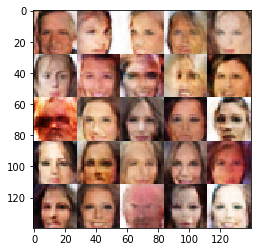

Epoch: 1/1 | Steps: 4510 | Discriminator Loss: 1.0752 | Generator Loss: 1.0787
Epoch: 1/1 | Steps: 4520 | Discriminator Loss: 1.1553 | Generator Loss: 0.9619
Epoch: 1/1 | Steps: 4530 | Discriminator Loss: 1.1053 | Generator Loss: 0.9102
Epoch: 1/1 | Steps: 4540 | Discriminator Loss: 1.0719 | Generator Loss: 1.0171
Epoch: 1/1 | Steps: 4550 | Discriminator Loss: 1.0921 | Generator Loss: 0.9233
Epoch: 1/1 | Steps: 4560 | Discriminator Loss: 1.0986 | Generator Loss: 1.0106
Epoch: 1/1 | Steps: 4570 | Discriminator Loss: 1.1371 | Generator Loss: 0.8704
Epoch: 1/1 | Steps: 4580 | Discriminator Loss: 1.2450 | Generator Loss: 0.8767
Epoch: 1/1 | Steps: 4590 | Discriminator Loss: 1.0660 | Generator Loss: 0.9212
Epoch: 1/1 | Steps: 4600 | Discriminator Loss: 1.2165 | Generator Loss: 0.7478


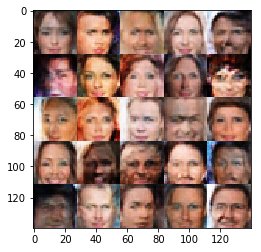

Epoch: 1/1 | Steps: 4610 | Discriminator Loss: 1.2408 | Generator Loss: 0.8060
Epoch: 1/1 | Steps: 4620 | Discriminator Loss: 1.1593 | Generator Loss: 0.8011
Epoch: 1/1 | Steps: 4630 | Discriminator Loss: 1.3191 | Generator Loss: 0.5680
Epoch: 1/1 | Steps: 4640 | Discriminator Loss: 1.1859 | Generator Loss: 1.0994
Epoch: 1/1 | Steps: 4650 | Discriminator Loss: 1.1833 | Generator Loss: 0.7385
Epoch: 1/1 | Steps: 4660 | Discriminator Loss: 1.3140 | Generator Loss: 0.7270
Epoch: 1/1 | Steps: 4670 | Discriminator Loss: 1.1507 | Generator Loss: 0.9161
Epoch: 1/1 | Steps: 4680 | Discriminator Loss: 1.1714 | Generator Loss: 0.9952
Epoch: 1/1 | Steps: 4690 | Discriminator Loss: 1.2244 | Generator Loss: 1.0259
Epoch: 1/1 | Steps: 4700 | Discriminator Loss: 1.1179 | Generator Loss: 1.1203


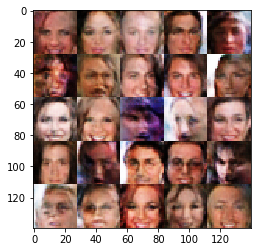

Epoch: 1/1 | Steps: 4710 | Discriminator Loss: 1.4338 | Generator Loss: 0.6560
Epoch: 1/1 | Steps: 4720 | Discriminator Loss: 1.3194 | Generator Loss: 0.6418
Epoch: 1/1 | Steps: 4730 | Discriminator Loss: 1.2144 | Generator Loss: 0.7398
Epoch: 1/1 | Steps: 4740 | Discriminator Loss: 1.3265 | Generator Loss: 0.7477
Epoch: 1/1 | Steps: 4750 | Discriminator Loss: 1.1036 | Generator Loss: 0.9801
Epoch: 1/1 | Steps: 4760 | Discriminator Loss: 1.2377 | Generator Loss: 0.6141
Epoch: 1/1 | Steps: 4770 | Discriminator Loss: 1.0473 | Generator Loss: 1.0614
Epoch: 1/1 | Steps: 4780 | Discriminator Loss: 1.1854 | Generator Loss: 0.9962
Epoch: 1/1 | Steps: 4790 | Discriminator Loss: 1.3020 | Generator Loss: 0.9007
Epoch: 1/1 | Steps: 4800 | Discriminator Loss: 1.2991 | Generator Loss: 0.7446


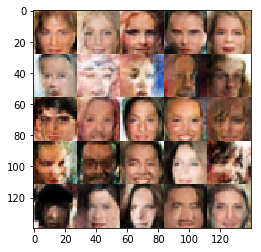

Epoch: 1/1 | Steps: 4810 | Discriminator Loss: 1.1810 | Generator Loss: 0.9815
Epoch: 1/1 | Steps: 4820 | Discriminator Loss: 1.2542 | Generator Loss: 0.6800
Epoch: 1/1 | Steps: 4830 | Discriminator Loss: 1.1358 | Generator Loss: 0.9448
Epoch: 1/1 | Steps: 4840 | Discriminator Loss: 0.9545 | Generator Loss: 1.3838
Epoch: 1/1 | Steps: 4850 | Discriminator Loss: 1.4219 | Generator Loss: 0.5734
Epoch: 1/1 | Steps: 4860 | Discriminator Loss: 1.1283 | Generator Loss: 1.0541
Epoch: 1/1 | Steps: 4870 | Discriminator Loss: 1.0786 | Generator Loss: 0.9636
Epoch: 1/1 | Steps: 4880 | Discriminator Loss: 1.0707 | Generator Loss: 0.9960
Epoch: 1/1 | Steps: 4890 | Discriminator Loss: 1.2033 | Generator Loss: 0.9818
Epoch: 1/1 | Steps: 4900 | Discriminator Loss: 1.3592 | Generator Loss: 0.5233


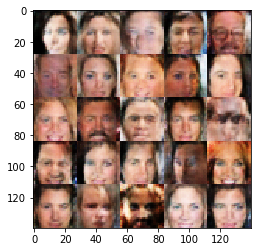

Epoch: 1/1 | Steps: 4910 | Discriminator Loss: 1.1783 | Generator Loss: 0.9120
Epoch: 1/1 | Steps: 4920 | Discriminator Loss: 1.4355 | Generator Loss: 0.6980
Epoch: 1/1 | Steps: 4930 | Discriminator Loss: 1.1386 | Generator Loss: 0.8665
Epoch: 1/1 | Steps: 4940 | Discriminator Loss: 1.2225 | Generator Loss: 0.9326
Epoch: 1/1 | Steps: 4950 | Discriminator Loss: 1.2903 | Generator Loss: 0.7571
Epoch: 1/1 | Steps: 4960 | Discriminator Loss: 1.2289 | Generator Loss: 0.8138
Epoch: 1/1 | Steps: 4970 | Discriminator Loss: 1.2062 | Generator Loss: 0.8238
Epoch: 1/1 | Steps: 4980 | Discriminator Loss: 1.1940 | Generator Loss: 0.8575
Epoch: 1/1 | Steps: 4990 | Discriminator Loss: 1.2099 | Generator Loss: 1.1975
Epoch: 1/1 | Steps: 5000 | Discriminator Loss: 0.9897 | Generator Loss: 0.8959


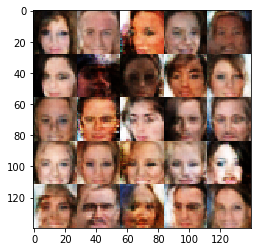

Epoch: 1/1 | Steps: 5010 | Discriminator Loss: 1.2395 | Generator Loss: 0.6312
Epoch: 1/1 | Steps: 5020 | Discriminator Loss: 1.2488 | Generator Loss: 0.7993
Epoch: 1/1 | Steps: 5030 | Discriminator Loss: 1.1391 | Generator Loss: 1.1077
Epoch: 1/1 | Steps: 5040 | Discriminator Loss: 1.1673 | Generator Loss: 1.0745
Epoch: 1/1 | Steps: 5050 | Discriminator Loss: 1.1149 | Generator Loss: 0.8821
Epoch: 1/1 | Steps: 5060 | Discriminator Loss: 1.1308 | Generator Loss: 0.8425
Epoch: 1/1 | Steps: 5070 | Discriminator Loss: 1.2356 | Generator Loss: 0.7715
Epoch: 1/1 | Steps: 5080 | Discriminator Loss: 1.4727 | Generator Loss: 0.4419
Epoch: 1/1 | Steps: 5090 | Discriminator Loss: 1.4254 | Generator Loss: 0.5652
Epoch: 1/1 | Steps: 5100 | Discriminator Loss: 1.2230 | Generator Loss: 0.9342


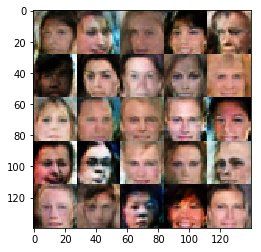

Epoch: 1/1 | Steps: 5110 | Discriminator Loss: 1.0234 | Generator Loss: 1.2126
Epoch: 1/1 | Steps: 5120 | Discriminator Loss: 1.0242 | Generator Loss: 0.9641
Epoch: 1/1 | Steps: 5130 | Discriminator Loss: 1.1429 | Generator Loss: 1.0488
Epoch: 1/1 | Steps: 5140 | Discriminator Loss: 1.2568 | Generator Loss: 0.7365
Epoch: 1/1 | Steps: 5150 | Discriminator Loss: 1.3960 | Generator Loss: 0.5483
Epoch: 1/1 | Steps: 5160 | Discriminator Loss: 1.3066 | Generator Loss: 0.6247
Epoch: 1/1 | Steps: 5170 | Discriminator Loss: 1.3843 | Generator Loss: 0.7423
Epoch: 1/1 | Steps: 5180 | Discriminator Loss: 1.3196 | Generator Loss: 0.6559
Epoch: 1/1 | Steps: 5190 | Discriminator Loss: 0.9594 | Generator Loss: 1.1699
Epoch: 1/1 | Steps: 5200 | Discriminator Loss: 1.2368 | Generator Loss: 0.8554


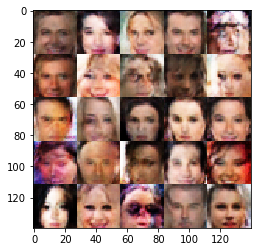

Epoch: 1/1 | Steps: 5210 | Discriminator Loss: 1.4924 | Generator Loss: 0.4933
Epoch: 1/1 | Steps: 5220 | Discriminator Loss: 1.2989 | Generator Loss: 0.6457
Epoch: 1/1 | Steps: 5230 | Discriminator Loss: 1.2518 | Generator Loss: 0.8657
Epoch: 1/1 | Steps: 5240 | Discriminator Loss: 1.1523 | Generator Loss: 0.8570
Epoch: 1/1 | Steps: 5250 | Discriminator Loss: 1.4482 | Generator Loss: 0.6420
Epoch: 1/1 | Steps: 5260 | Discriminator Loss: 1.2247 | Generator Loss: 0.8578
Epoch: 1/1 | Steps: 5270 | Discriminator Loss: 1.3691 | Generator Loss: 0.6153
Epoch: 1/1 | Steps: 5280 | Discriminator Loss: 1.0701 | Generator Loss: 1.0420
Epoch: 1/1 | Steps: 5290 | Discriminator Loss: 1.1767 | Generator Loss: 0.7373
Epoch: 1/1 | Steps: 5300 | Discriminator Loss: 1.2599 | Generator Loss: 0.9115


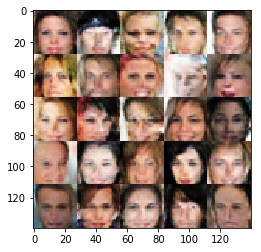

Epoch: 1/1 | Steps: 5310 | Discriminator Loss: 1.2736 | Generator Loss: 1.1474
Epoch: 1/1 | Steps: 5320 | Discriminator Loss: 1.0224 | Generator Loss: 1.2664
Epoch: 1/1 | Steps: 5330 | Discriminator Loss: 1.1311 | Generator Loss: 1.0126
Epoch: 1/1 | Steps: 5340 | Discriminator Loss: 1.1866 | Generator Loss: 0.8912
Epoch: 1/1 | Steps: 5350 | Discriminator Loss: 1.1744 | Generator Loss: 0.9431
Epoch: 1/1 | Steps: 5360 | Discriminator Loss: 1.2415 | Generator Loss: 0.8719
Epoch: 1/1 | Steps: 5370 | Discriminator Loss: 1.1229 | Generator Loss: 1.0439
Epoch: 1/1 | Steps: 5380 | Discriminator Loss: 1.1523 | Generator Loss: 0.7365
Epoch: 1/1 | Steps: 5390 | Discriminator Loss: 1.1607 | Generator Loss: 0.8619
Epoch: 1/1 | Steps: 5400 | Discriminator Loss: 1.1232 | Generator Loss: 0.7970


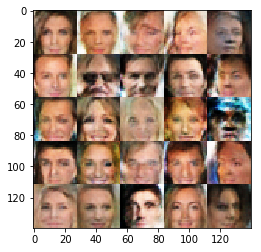

Epoch: 1/1 | Steps: 5410 | Discriminator Loss: 1.0660 | Generator Loss: 1.1582
Epoch: 1/1 | Steps: 5420 | Discriminator Loss: 1.3323 | Generator Loss: 0.7504
Epoch: 1/1 | Steps: 5430 | Discriminator Loss: 1.0876 | Generator Loss: 0.9916
Epoch: 1/1 | Steps: 5440 | Discriminator Loss: 1.0560 | Generator Loss: 1.0139
Epoch: 1/1 | Steps: 5450 | Discriminator Loss: 1.2959 | Generator Loss: 0.5661
Epoch: 1/1 | Steps: 5460 | Discriminator Loss: 1.2866 | Generator Loss: 0.6350
Epoch: 1/1 | Steps: 5470 | Discriminator Loss: 1.2170 | Generator Loss: 0.8640
Epoch: 1/1 | Steps: 5480 | Discriminator Loss: 1.2467 | Generator Loss: 1.1422
Epoch: 1/1 | Steps: 5490 | Discriminator Loss: 1.2017 | Generator Loss: 0.8123
Epoch: 1/1 | Steps: 5500 | Discriminator Loss: 1.3268 | Generator Loss: 0.6934


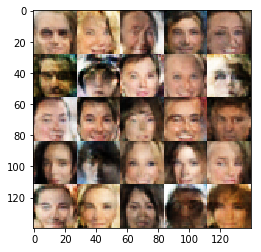

Epoch: 1/1 | Steps: 5510 | Discriminator Loss: 1.0776 | Generator Loss: 0.8964
Epoch: 1/1 | Steps: 5520 | Discriminator Loss: 1.1067 | Generator Loss: 0.9290
Epoch: 1/1 | Steps: 5530 | Discriminator Loss: 1.1989 | Generator Loss: 0.8587
Epoch: 1/1 | Steps: 5540 | Discriminator Loss: 1.2017 | Generator Loss: 0.9019
Epoch: 1/1 | Steps: 5550 | Discriminator Loss: 1.1543 | Generator Loss: 1.0503
Epoch: 1/1 | Steps: 5560 | Discriminator Loss: 1.1976 | Generator Loss: 0.7214
Epoch: 1/1 | Steps: 5570 | Discriminator Loss: 1.2009 | Generator Loss: 1.0823
Epoch: 1/1 | Steps: 5580 | Discriminator Loss: 1.2932 | Generator Loss: 0.5610
Epoch: 1/1 | Steps: 5590 | Discriminator Loss: 1.0529 | Generator Loss: 0.8714
Epoch: 1/1 | Steps: 5600 | Discriminator Loss: 1.1786 | Generator Loss: 0.8888


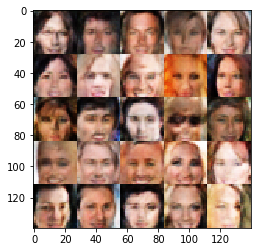

Epoch: 1/1 | Steps: 5610 | Discriminator Loss: 1.3152 | Generator Loss: 0.5664
Epoch: 1/1 | Steps: 5620 | Discriminator Loss: 1.2222 | Generator Loss: 0.6982
Epoch: 1/1 | Steps: 5630 | Discriminator Loss: 1.2400 | Generator Loss: 0.9896
Epoch: 1/1 | Steps: 5640 | Discriminator Loss: 1.3423 | Generator Loss: 0.7269
Epoch: 1/1 | Steps: 5650 | Discriminator Loss: 1.1789 | Generator Loss: 0.8522
Epoch: 1/1 | Steps: 5660 | Discriminator Loss: 1.0551 | Generator Loss: 0.9773
Epoch: 1/1 | Steps: 5670 | Discriminator Loss: 1.1718 | Generator Loss: 0.7190
Epoch: 1/1 | Steps: 5680 | Discriminator Loss: 1.3549 | Generator Loss: 0.6880
Epoch: 1/1 | Steps: 5690 | Discriminator Loss: 1.0384 | Generator Loss: 0.9330
Epoch: 1/1 | Steps: 5700 | Discriminator Loss: 1.1918 | Generator Loss: 1.0020


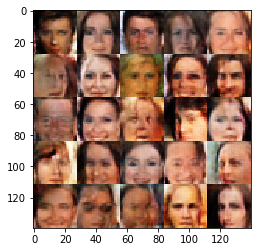

Epoch: 1/1 | Steps: 5710 | Discriminator Loss: 1.1943 | Generator Loss: 0.8684
Epoch: 1/1 | Steps: 5720 | Discriminator Loss: 1.1854 | Generator Loss: 0.9919
Epoch: 1/1 | Steps: 5730 | Discriminator Loss: 1.3749 | Generator Loss: 0.5624
Epoch: 1/1 | Steps: 5740 | Discriminator Loss: 1.1567 | Generator Loss: 0.8339
Epoch: 1/1 | Steps: 5750 | Discriminator Loss: 1.1035 | Generator Loss: 0.9412
Epoch: 1/1 | Steps: 5760 | Discriminator Loss: 1.1688 | Generator Loss: 0.9520
Epoch: 1/1 | Steps: 5770 | Discriminator Loss: 1.0438 | Generator Loss: 1.0195
Epoch: 1/1 | Steps: 5780 | Discriminator Loss: 1.1351 | Generator Loss: 0.8074
Epoch: 1/1 | Steps: 5790 | Discriminator Loss: 1.1893 | Generator Loss: 0.6514
Epoch: 1/1 | Steps: 5800 | Discriminator Loss: 1.1423 | Generator Loss: 0.8699


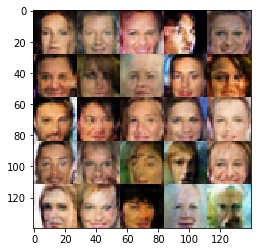

Epoch: 1/1 | Steps: 5810 | Discriminator Loss: 1.5382 | Generator Loss: 0.6063
Epoch: 1/1 | Steps: 5820 | Discriminator Loss: 1.0383 | Generator Loss: 0.8915
Epoch: 1/1 | Steps: 5830 | Discriminator Loss: 1.1683 | Generator Loss: 1.0997
Epoch: 1/1 | Steps: 5840 | Discriminator Loss: 1.1144 | Generator Loss: 1.0261
Epoch: 1/1 | Steps: 5850 | Discriminator Loss: 1.3765 | Generator Loss: 0.9541
Epoch: 1/1 | Steps: 5860 | Discriminator Loss: 1.2532 | Generator Loss: 1.1380
Epoch: 1/1 | Steps: 5870 | Discriminator Loss: 1.1493 | Generator Loss: 0.8715
Epoch: 1/1 | Steps: 5880 | Discriminator Loss: 1.2417 | Generator Loss: 1.0229
Epoch: 1/1 | Steps: 5890 | Discriminator Loss: 1.0294 | Generator Loss: 1.1654
Epoch: 1/1 | Steps: 5900 | Discriminator Loss: 1.0059 | Generator Loss: 1.0201


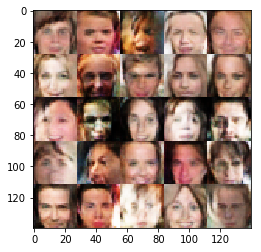

Epoch: 1/1 | Steps: 5910 | Discriminator Loss: 1.3201 | Generator Loss: 0.5917
Epoch: 1/1 | Steps: 5920 | Discriminator Loss: 1.1604 | Generator Loss: 0.7767
Epoch: 1/1 | Steps: 5930 | Discriminator Loss: 1.1430 | Generator Loss: 0.7957
Epoch: 1/1 | Steps: 5940 | Discriminator Loss: 1.1818 | Generator Loss: 0.7697
Epoch: 1/1 | Steps: 5950 | Discriminator Loss: 1.1047 | Generator Loss: 1.1547
Epoch: 1/1 | Steps: 5960 | Discriminator Loss: 1.2255 | Generator Loss: 0.7054
Epoch: 1/1 | Steps: 5970 | Discriminator Loss: 1.2273 | Generator Loss: 0.7669
Epoch: 1/1 | Steps: 5980 | Discriminator Loss: 1.3298 | Generator Loss: 0.7166
Epoch: 1/1 | Steps: 5990 | Discriminator Loss: 1.0779 | Generator Loss: 1.1498
Epoch: 1/1 | Steps: 6000 | Discriminator Loss: 1.1485 | Generator Loss: 1.1366


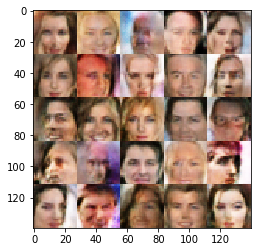

Epoch: 1/1 | Steps: 6010 | Discriminator Loss: 1.1756 | Generator Loss: 1.0234
Epoch: 1/1 | Steps: 6020 | Discriminator Loss: 1.2247 | Generator Loss: 0.7212
Epoch: 1/1 | Steps: 6030 | Discriminator Loss: 1.0860 | Generator Loss: 1.3361
Epoch: 1/1 | Steps: 6040 | Discriminator Loss: 1.2520 | Generator Loss: 0.8230
Epoch: 1/1 | Steps: 6050 | Discriminator Loss: 1.2663 | Generator Loss: 0.9017
Epoch: 1/1 | Steps: 6060 | Discriminator Loss: 1.0623 | Generator Loss: 1.0922
Epoch: 1/1 | Steps: 6070 | Discriminator Loss: 1.4482 | Generator Loss: 0.5526
Epoch: 1/1 | Steps: 6080 | Discriminator Loss: 1.2656 | Generator Loss: 1.1489
Epoch: 1/1 | Steps: 6090 | Discriminator Loss: 1.1763 | Generator Loss: 0.8131
Epoch: 1/1 | Steps: 6100 | Discriminator Loss: 0.9963 | Generator Loss: 0.9605


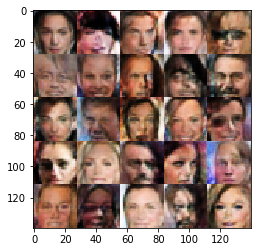

Epoch: 1/1 | Steps: 6110 | Discriminator Loss: 1.2943 | Generator Loss: 0.6869
Epoch: 1/1 | Steps: 6120 | Discriminator Loss: 1.0843 | Generator Loss: 0.9071
Epoch: 1/1 | Steps: 6130 | Discriminator Loss: 1.2406 | Generator Loss: 1.1963
Epoch: 1/1 | Steps: 6140 | Discriminator Loss: 1.1548 | Generator Loss: 0.9594
Epoch: 1/1 | Steps: 6150 | Discriminator Loss: 1.0209 | Generator Loss: 1.1309
Epoch: 1/1 | Steps: 6160 | Discriminator Loss: 1.2155 | Generator Loss: 0.9305
Epoch: 1/1 | Steps: 6170 | Discriminator Loss: 1.1697 | Generator Loss: 1.0921
Epoch: 1/1 | Steps: 6180 | Discriminator Loss: 1.1995 | Generator Loss: 0.8034
Epoch: 1/1 | Steps: 6190 | Discriminator Loss: 1.3900 | Generator Loss: 0.6898
Epoch: 1/1 | Steps: 6200 | Discriminator Loss: 1.0493 | Generator Loss: 1.2127


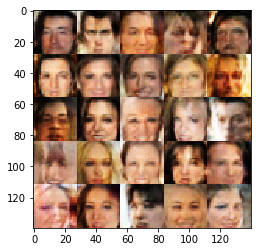

Epoch: 1/1 | Steps: 6210 | Discriminator Loss: 1.0541 | Generator Loss: 1.0184
Epoch: 1/1 | Steps: 6220 | Discriminator Loss: 1.2801 | Generator Loss: 0.7503
Epoch: 1/1 | Steps: 6230 | Discriminator Loss: 1.0717 | Generator Loss: 0.7534
Epoch: 1/1 | Steps: 6240 | Discriminator Loss: 1.5082 | Generator Loss: 0.5363
Epoch: 1/1 | Steps: 6250 | Discriminator Loss: 1.2472 | Generator Loss: 1.1016
Epoch: 1/1 | Steps: 6260 | Discriminator Loss: 1.2217 | Generator Loss: 0.8194
Epoch: 1/1 | Steps: 6270 | Discriminator Loss: 1.2697 | Generator Loss: 0.8394
Epoch: 1/1 | Steps: 6280 | Discriminator Loss: 1.0913 | Generator Loss: 0.9693
Epoch: 1/1 | Steps: 6290 | Discriminator Loss: 1.2353 | Generator Loss: 0.7864
Epoch: 1/1 | Steps: 6300 | Discriminator Loss: 1.2013 | Generator Loss: 0.7249


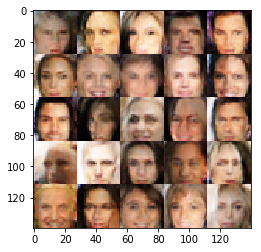

Epoch: 1/1 | Steps: 6310 | Discriminator Loss: 1.2849 | Generator Loss: 0.5100
Epoch: 1/1 | Steps: 6320 | Discriminator Loss: 1.1743 | Generator Loss: 0.9411
Epoch: 1/1 | Steps: 6330 | Discriminator Loss: 1.3253 | Generator Loss: 0.6748


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)